# 🌸 Floranet

---
- 902011, Moleri Andrea, a.moleri@campus.unimib.it
- 865939, Armani Filippo, f.armani1@campus.unimib.it
---

## 🎯 Domain and Objectives

The notebook you are about to read contains a project called Floranet, which aims to classify, through the use of machine learning and deep learning techniques, a dataset containing 102 classes of different flowers. In particular, the dataset used is known as the [Oxford Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html), compiled by Maria-Elena Nilsback and Andrew Zisserman. Each of the 102 classes consists of a variable number ranging from 40 to 258 images per class. The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories. The dataset is visualized using isomap with shape and colour features. Our aim is therefore to investigate the possibilities of building models in order to solve the classification task. In other words, given an image of a flower, we want to be able to correctly identify and recognize the flower in question, minimizing the margin of error as much as possible.

## 💾 Importing the Data

In the following code cell, we download and prepare the dataset required for later analysis. The process begins by specifying a list of URLs for the required files, including images (`102flowers.tgz`), segmentation masks (`102segmentations.tgz`), and a MATLAB file containing labels (`imagelabels.mat`). First, the code checks whether a directory named `Data` exists in the parent directory. If it does not, the directory is created. For each URL in the list, the script extracts the file name from the URL, checks whether the file already exists in the target directory, and downloads it if missing. The progress is communicated to the user via messages printed in the console.

For files that require further processing (such as decompression), a helper function named `decompress` is invoked. This function uses the Python `tarfile` module to extract the compressed content into the target directory. For better organization, the function also renames the extracted directories to meaningful names like `images` and `segmented_images`. The output of the cell confirms whether each file already exists or has been newly downloaded. If decompression is needed, the appropriate subdirectories are created to store the prepared data. Please note that the `segmented_images` archive has been imported for completeness’s sake with respect to the original dataset, but will not be used in the project at hand. However, it remains available if, in the future, changes in the scope of the notebook or alternative tasks to be carried out were to require it.

In [2]:
import os
import pathlib
import tarfile
import requests
import shutil

def decompress(url, out_dir, old_name, new_name):
    """
    Decompresses a tar.gz file and moves a specific folder to a new location.

    Parameters:
    url (str): The URL of the file to be decompressed.
    out_dir (str): The output directory where the file is decompressed.
    old_name (str): The name of the folder inside the decompressed archive.
    new_name (str): The new name and location for the folder after decompression.

    Returns:
    None
    """
    file_name = url.split('/')[-1]
    file_path = os.path.join(out_dir, file_name)

    print(f"Extracting {file_name}...", end=" ")

    # Open the tar.gz file and extract its contents to the output directory
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=out_dir)

    # Rename (or move) the extracted folder
    shutil.move(old_name, new_name)

    print(f"Completed!")

# URLs of the resources to be downloaded
url = ["https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz",
       "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz",
       "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"]

# Define the output directory
out_dir = os.path.join(pathlib.Path('./').parent.absolute(), "Data")
os.makedirs(out_dir, exist_ok=True)  # Create the directory if it does not exist

# Iterate through each URL and download the file if it does not already exist
for u in url:
    file_name = u.split('/')[-1]  # Extract the file name from the URL
    file_path = os.path.join(out_dir, file_name)  # Full path for the downloaded file

    if not os.path.exists(file_path):
        print(f"Downloading {file_name}...", end=" ")
        response = requests.get(u)  # Perform the HTTP GET request
        with open(file_path, 'wb') as f:
            f.write(response.content)  # Save the content to a file
        print(f"Completed!")
    else:
        print(f"The file {file_name} already exists.")  # Skip download if the file exists

# Define directories for decompressed content
images_dir = os.path.join(out_dir, "images")
segmented_dir = os.path.join(out_dir, "segmented_images")
labels_path = os.path.join(out_dir, 'imagelabels.mat')

# Decompress and organize the flower images
if not os.path.exists(images_dir):
    decompress(url[0], out_dir, os.path.join(out_dir, "jpg"), images_dir)

# Decompress and organize the segmented images
if not os.path.exists(segmented_dir):
    decompress(url[1], out_dir, os.path.join(out_dir, "segmim"), segmented_dir)

The file 102flowers.tgz already exists.
The file 102segmentations.tgz already exists.
The file imagelabels.mat already exists.


##  🏷️ Mapping Images to Labels

The following code cell is designed to map the image files of the dataset to their respective flower names using the labels provided in the `imagelabels.mat` file. The MATLAB file containing the labels is loaded using the `scipy.io.loadmat` function. The flower class labels are stored in the `labels` variable, and since MATLAB indices start at 1, these are adjusted for Python's 0-based indexing. Additionally, a list of flower names is used to map class indices to human-readable flower names. For reference, the Oxford University website (the same one we got the dataset from) lists the 102 categories that make up the dataset, [each with an associated image.](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html) This web page was helpful in verifying that the label mapping in the following code cell was formally correct. This mapping is facilitated by the `ID_NAMES` dictionary, where each index is paired with its corresponding flower name.

In a nutshell, the script identifies all image files in the `images_dir` directory, ensuring only `.jpg` files are considered. These file names are sorted to align with the order of the labels in the dataset. A list comprehension is used to retrieve the flower names corresponding to the labels for each image. Finally, the `image_name` and `flower_name` pairs are stored in a dictionary and converted into a Pandas DataFrame for easier manipulation and analysis. This DataFrame (`df`) serves as a structured representation of the dataset, where each row links an image file to its associated flower name. Although the step of associating "human-readable" labels to images is not useful for machine learning purposes, it is still useful to apply it in order to better comment on the data analysis phase conducted in the code cell that is located after the one you are reading right now.

In [3]:
import os
from scipy.io import loadmat
import pandas as pd

# Load the labels from the .mat file
labels_data = loadmat(labels_path)  # Load MATLAB data as a dictionary
labels = labels_data['labels'][0]  # Extract the labels array from the dictionary

# Define the flower names corresponding to the label IDs
NAMES = [
    "Pink Primrose", "Hard-Leaved Pocket Orchid", "Canterbury Bells",
    "Sweet Pea", "English Marigold", "Tiger Lily", "Moon Orchid",
    "Bird Of Paradise", "Monkshood", "Globe Thistle", "Snapdragon",
    "Colt's Foot", "King Protea", "Spear Thistle", "Yellow Iris",
    "Globe-Flower", "Purple Coneflower", "Peruvian Lily", "Balloon Flower",
    "Giant White Arum Lily", "Fire Lily", "Pincushion Flower", "Fritillary",
    "Red Ginger", "Grape Hyacinth", "Corn Poppy", "Prince Of Wales Feathers",
    "Stemless Gentian", "Artichoke", "Sweet William", "Carnation",
    "Garden Phlox", "Love In The Mist", "Mexican Aster", "Alpine Sea Holly",
    "Ruby-Lipped Cattleya", "Cape Flower", "Great Masterwort", "Siam Tulip",
    "Lenten Rose", "Barbeton Daisy", "Daffodil", "Sword Lily", "Poinsettia",
    "Bolero Deep Blue", "Wallflower", "Marigold", "Buttercup", "Oxeye Daisy",
    "Common Dandelion", "Petunia", "Wild Pansy", "Primula", "Sunflower",
    "Pelargonium", "Bishop Of Llandaff", "Gaura", "Geranium", "Orange Dahlia",
    "Pink-Yellow Dahlia?", "Cautleya Spicata", "Japanese Anemone",
    "Black-Eyed Susan", "Silverbush", "Californian Poppy", "Osteospermum",
    "Spring Crocus", "Bearded Iris", "Windflower", "Tree Poppy", "Gazania",
    "Azalea", "Water Lily", "Rose", "Thorn Apple", "Morning Glory",
    "Passion Flower", "Lotus", "Toad Lily", "Anthurium", "Frangipani",
    "Clematis", "Hibiscus", "Columbine", "Desert-Rose", "Tree Mallow",
    "Magnolia", "Cyclamen", "Watercress", "Canna Lily", "Hippeastrum",
    "Bee Balm", "Ball Moss", "Foxglove", "Bougainvillea", "Camellia", "Mallow",
    "Mexican Petunia", "Bromelia", "Blanket Flower", "Trumpet Creeper",
    "Blackberry Lily"
]

# Map label IDs (0-indexed) to flower names
ID_NAMES = dict(zip([x for x in range(len(NAMES))], NAMES))

# Retrieve the sorted list of image file names
image_files = sorted([img for img in os.listdir(images_dir) if img.endswith('.jpg')])

# Map the labels to their corresponding flower names, ensuring correct indexing
flower_names = [ID_NAMES[label - 1] for label in labels[:len(image_files)]]

# Create a dictionary for the DataFrame
data = {'image_name': image_files, 'flower_name': flower_names}

# Create a pandas DataFrame to organize the image and flower data
df = pd.DataFrame(data)

# Display a random mapping example
display(df.sample(10))

image_name         flower_name
4116  image_04117.jpg           Artichoke
7654  image_07655.jpg            Camellia
2514  image_02515.jpg       Morning Glory
5331  image_05332.jpg          Tree Poppy
2813  image_02814.jpg  Bishop Of Llandaff
7999  image_08000.jpg     Blackberry Lily
545   image_00546.jpg            Cyclamen
805   image_00806.jpg          Frangipani
3479  image_03480.jpg       Sweet William
2797  image_02798.jpg  Bishop Of Llandaff

## 🔎 Analyzing the Data

The following code cell performs an analysis of the training data, offering valuable insights into its composition, structure, and dynamics. The analysis involves both quantitative summaries and qualitative visualizations. The dataset comprises a total of `8,189` images, distributed across `102` flower classes. The class distribution is uneven, with the most populated class containing `258` images (Petunia) and the least populated class containing `40` images (e.g., Pink Primrose). This may highlight the need for potential class-balancing strategies during model training. In this regard, a bar plot illustrates the distribution of images per class, offering a clear visual interpretation of the imbalances across categories. Classes such as Petunia and Passion Flower dominate the dataset, while several classes have fewer samples, which might pose challenges when training CNN models.

To provide a qualitative understanding, sample images from the top 5 most populated classes are displayed. Each row in the grid corresponds to a class, showcasing five randomly chosen images belonging to the class in question. This visualization provides insights into intra-class variability and image quality. Regarding this visualization, we start to recognize interesting phenomena. First, the Petunia class presents a clear example of pose variation. In other words, objects within the same category can be presented in several different poses and angles. Furthermore, the Wallflower and the Watercress classes present an example of inter-class similarity. This means that objects in the two classes could easily be confused with each other. Finally, we notice that the Water Lily class presents intra-class variation. Simply put, objects within the same category can have striking differences in appearance. Furthermore, a comparison is made between flowers extracted from 10 randomly selected classes, and flowers extracted from a specific class. This visualization was made to underscore the diversity within the dataset, and to highlight the consistency of samples for a particular category at the same time.

After these visualizations, the dimensions (width and height) of all images were analyzed to compute statistics such as mean, standard deviation, and range. The dataset exhibits varying resolutions, with an average image size of approximately `630×534` pixels. The aspect ratio distribution was plotted, showing a concentration around `1.2` with some outliers. These findings indicate relatively uniform image dimensions, simplifying preprocessing requirements. While these aspect ratio variations shouldn't cause any problems, it's still a good idea to keep them in mind, as the images will need to be rescaled to be properly fed into the convolutional neural networks we'll build. Finally, the average number of images per class is `80.28`, but the significant variance value highlights potential issues of class imbalance. Strategies such as data augmentation may be necessary to mitigate the impact during training.

Total number of images: 8189

Number of images per class (ordered by count):
Class | Petunia: 258 images
Class | Passion Flower: 251 images
Class | Wallflower: 196 images
Class | Water Lily: 194 images
Class | Watercress: 184 images
Class | Rose: 171 images
Class | Frangipani: 166 images
Class | Foxglove: 162 images
Class | Cyclamen: 154 images
Class | Lotus: 137 images
Class | Hibiscus: 131 images
Class | Sword Lily: 130 images
Class | Bougainvillea: 128 images
Class | Barbeton Daisy: 127 images
Class | Thorn Apple: 120 images
Class | Geranium: 114 images
Class | Clematis: 112 images
Class | Bishop Of Llandaff: 109 images
Class | Pink-Yellow Dahlia?: 109 images
Class | Cape Flower: 108 images
Class | Morning Glory: 107 images
Class | Anthurium: 105 images
Class | Californian Poppy: 102 images
Class | Azalea: 96 images
Class | Primula: 93 images
Class | Poinsettia: 93 images
Class | Common Dandelion: 92 images
Class | Fritillary: 91 images
Class | Camellia: 91 images
Class | Snapdragon

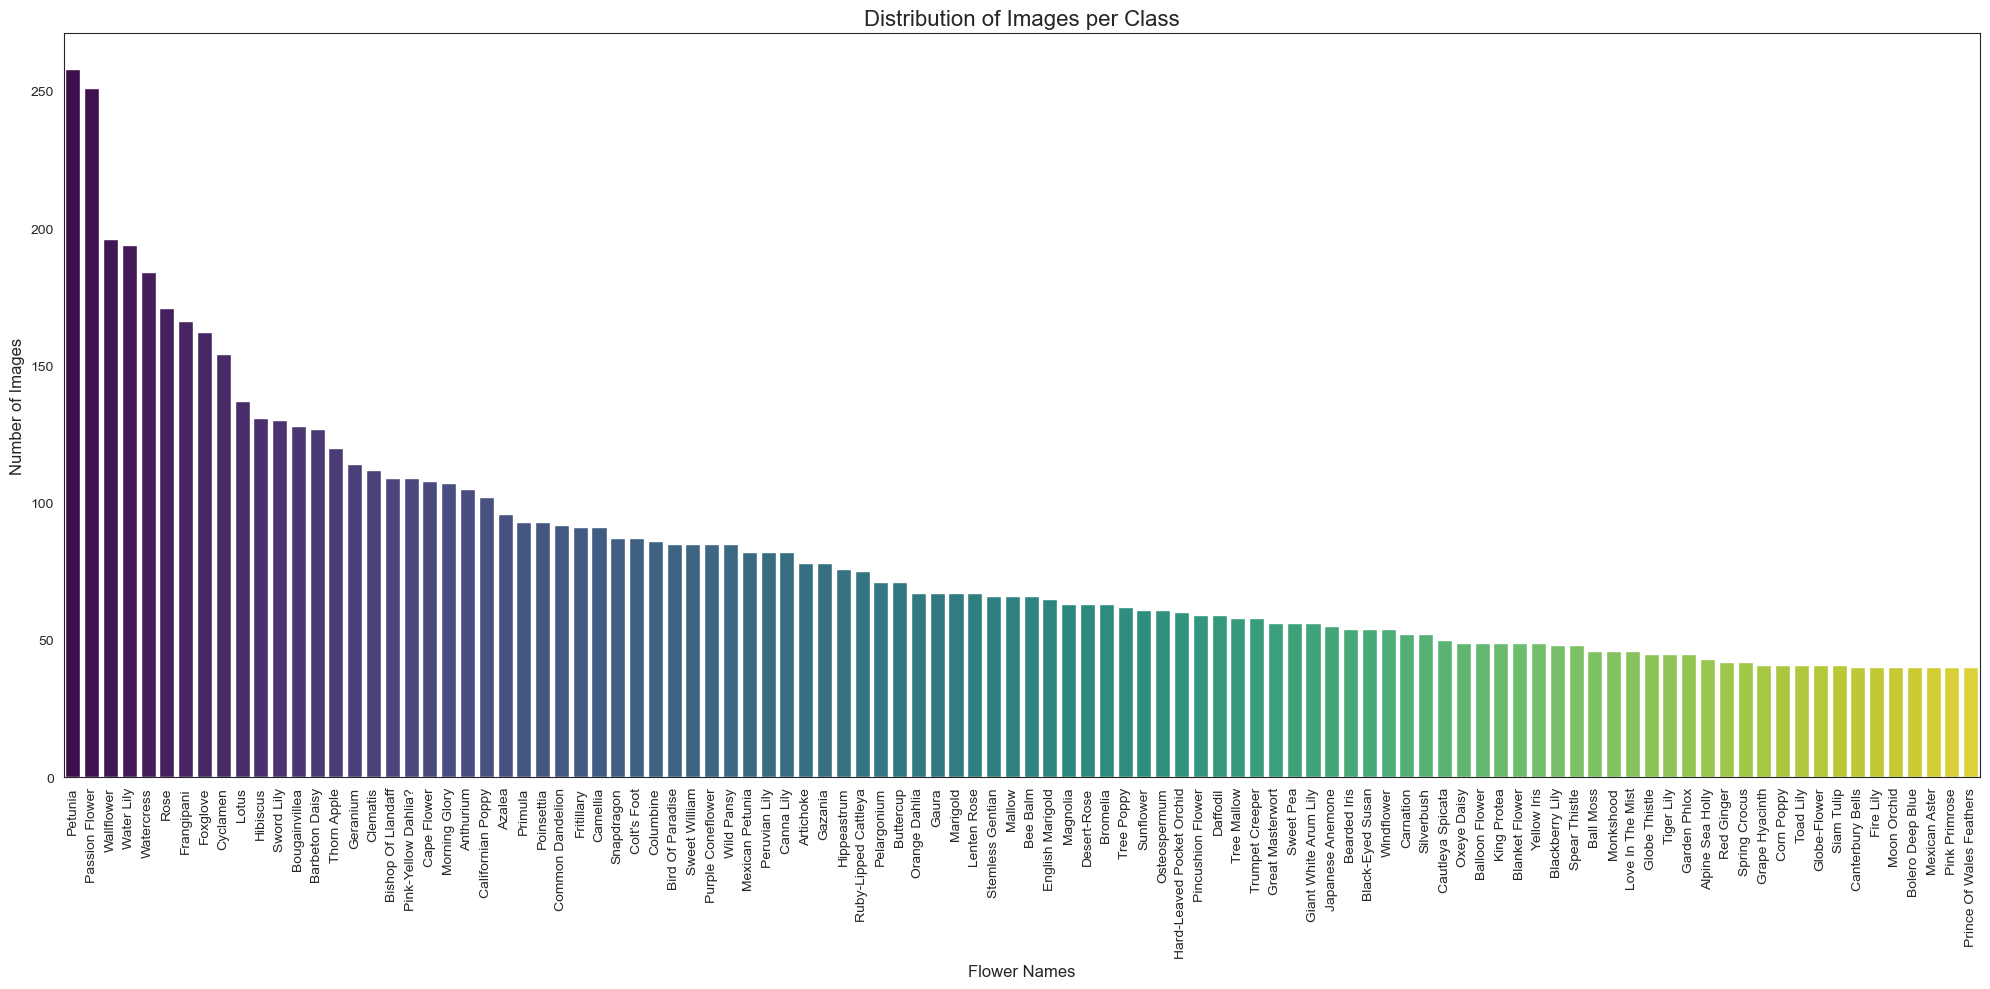

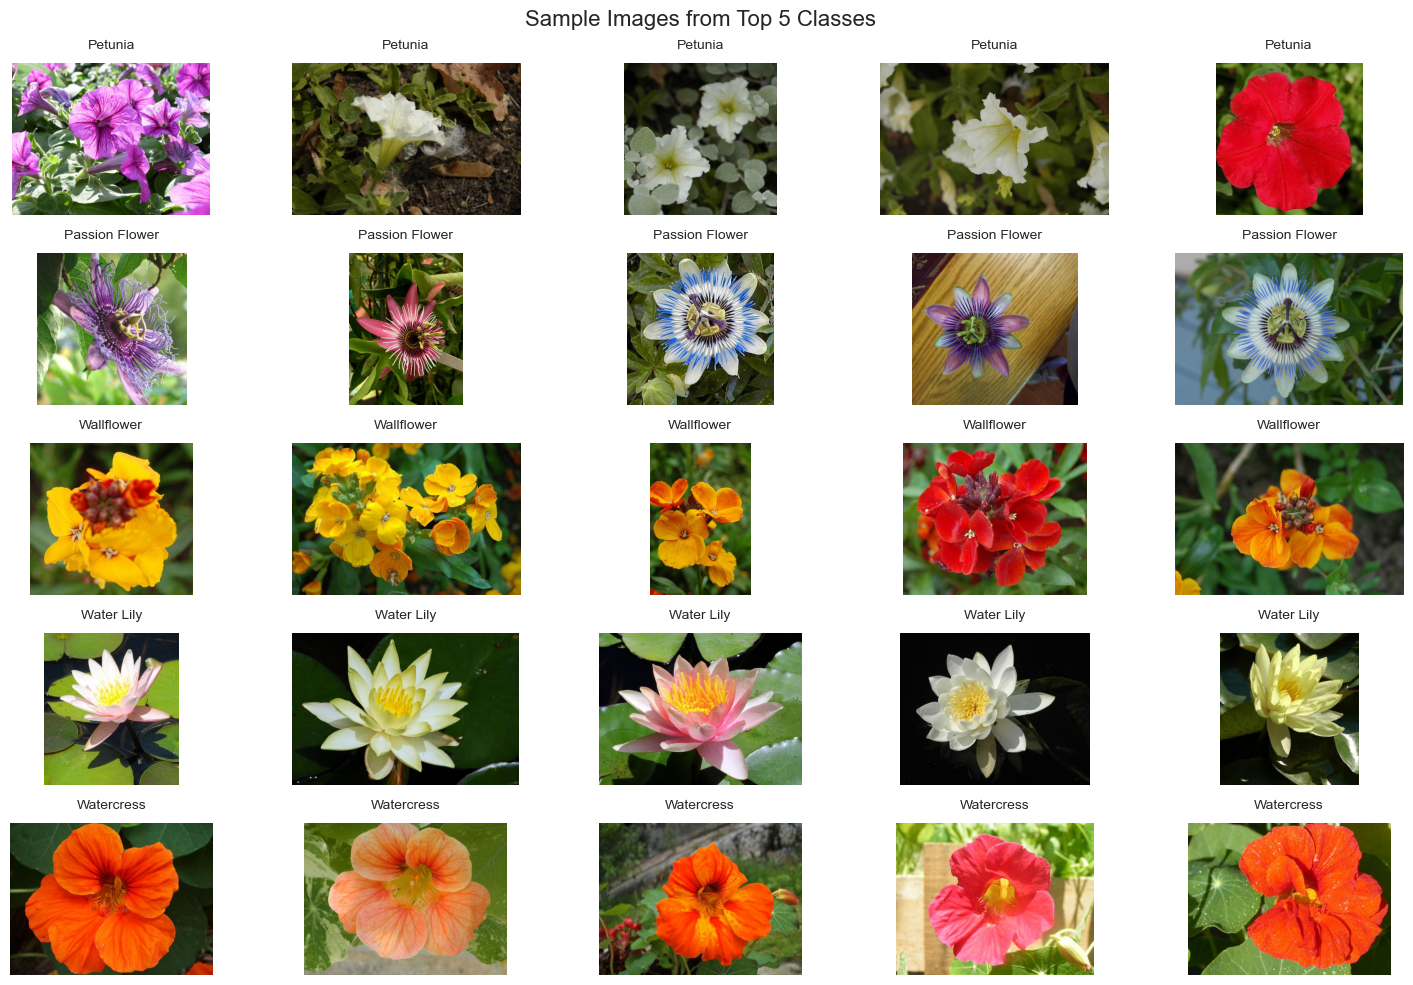

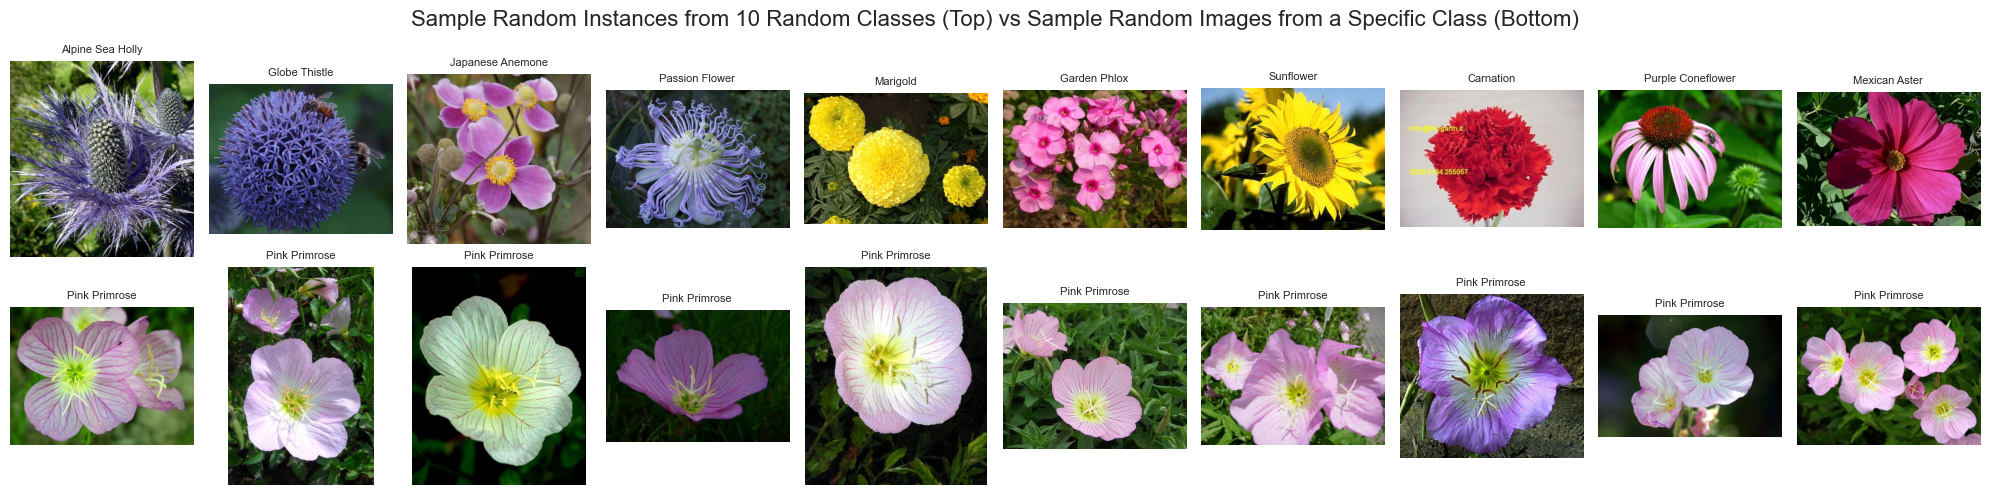

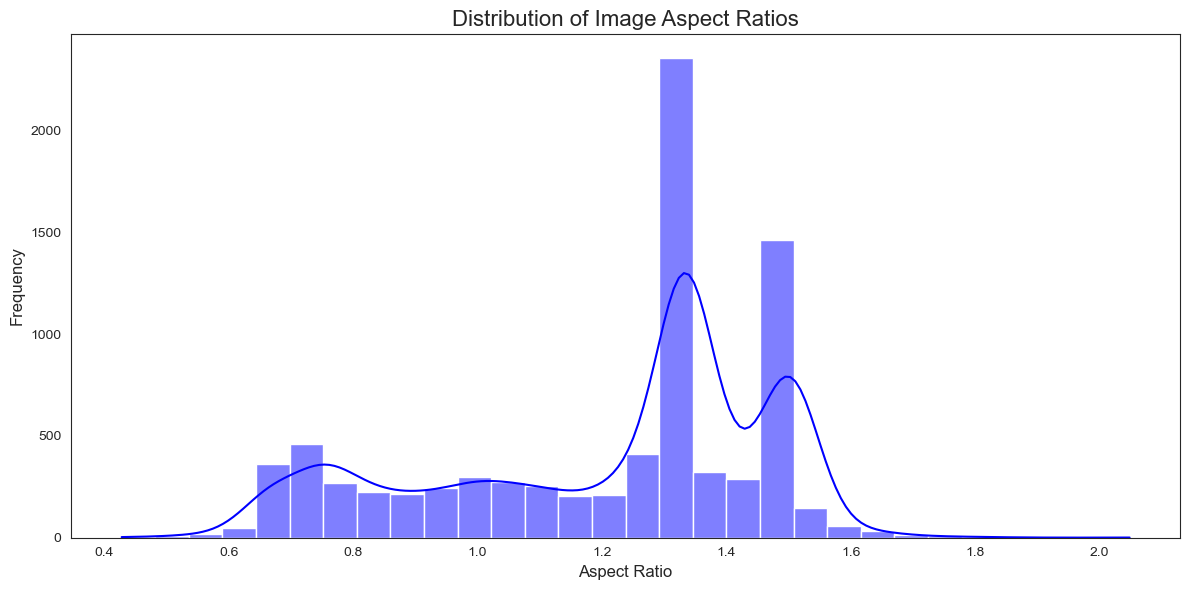


Image Dimension Statistics:
             Width       Height  Aspect Ratio
count  8189.000000  8189.000000   8189.000000
mean    630.160581   534.352058      1.210391
std      95.988254    75.453540      0.270855
min     500.000000   500.000000      0.428082
25%     501.000000   500.000000      1.000000
50%     667.000000   500.000000      1.332000
75%     699.000000   501.000000      1.398000
max    1024.000000  1168.000000      2.048000

Average number of images per class: 80.28


In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Print the total number of images in the dataset
num_images = len(df)
print(f"Total number of images: {num_images}")

# Count the number of images per class
images_per_class = df['flower_name'].value_counts()
print("\nNumber of images per class (ordered by count):")
for flower_name, count in images_per_class.items():
    print(f"Class | {flower_name}: {count} images")

# Plot the distribution of images per class
plt.figure(figsize=(20, 10))
sns.set_style("white")
sns.barplot(x=images_per_class.index, y=images_per_class.values, hue=images_per_class.index, dodge=False, palette="viridis", legend=False)
plt.xlabel('Flower Names', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Images per Class', fontsize=16)
plt.xticks(rotation=90)  # Rotate for better visibility
plt.tight_layout()
plt.show()

# Display sample images from the top 5 classes by image count
top_classes = images_per_class.head(5).index

fig, axes = plt.subplots(len(top_classes), 5, figsize=(15, 10))
for i, flower_name in enumerate(top_classes):
    # Randomly sample 5 images for the current flower class
    sample_images = df[df['flower_name'] == flower_name].sample(5)['image_name'].values
    for j, image_name in enumerate(sample_images):
        img_path = os.path.join(images_dir, image_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')  # Hide axis for better visualization
        axes[i, j].set_title(f"{flower_name}", fontsize=10, pad=10)
plt.suptitle('Sample Images from Top 5 Classes', fontsize=16)
plt.tight_layout()
plt.show()

# Randomly sample 10 flower classes and 10 images from a specific class
random_classes = df['flower_name'].drop_duplicates().sample(10).values
class_1_images = df[df['flower_name'] == NAMES[0]].sample(10)['image_name'].values

# Plot images from random classes (top row) and specific class (bottom row)
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for i, flower_name in enumerate(random_classes):
    # Randomly sample one image for each random class
    image_name = df[df['flower_name'] == flower_name].sample(1)['image_name'].values[0]
    img_path = os.path.join(images_dir, image_name)
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"{flower_name}", fontsize=8)

for i, image_name in enumerate(class_1_images):
    # Display 10 random images for the specific flower class
    img_path = os.path.join(images_dir, image_name)
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title("Pink Primrose", fontsize=8)

plt.suptitle('Sample Random Instances from 10 Random Classes (Top) vs Sample Random Images from a Specific Class (Bottom)', fontsize=16)
plt.tight_layout()
plt.show()

# Analyze image dimensions (width and height)
image_sizes = []
for image_name in df['image_name']:
    img_path = os.path.join(images_dir, image_name)
    with Image.open(img_path) as img:
        image_sizes.append(img.size)  # Append image dimensions as (width, height)

# Create a DataFrame for image sizes and calculate aspect ratios
sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
sizes_df['Aspect Ratio'] = sizes_df['Width'] / sizes_df['Height']

# Plot the distribution of image aspect ratios
plt.figure(figsize=(12, 6))
sns.histplot(sizes_df['Aspect Ratio'], kde=True, color='blue', bins=30)
plt.xlabel('Aspect Ratio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Image Aspect Ratios', fontsize=16)
plt.tight_layout()
plt.show()

# Print summary statistics for image dimensions
print("\nImage Dimension Statistics:")
print(sizes_df.describe())

# Calculate and print the average number of images per class
avg_images_per_class = images_per_class.mean()
print(f"\nAverage number of images per class: {avg_images_per_class:.2f}")

## 🗂️ Creating Training, Validation and Test Sets

In the following code cell, the dataset has been split into three sets: a training set, a validation set, and a test set, with the training set containing `70%` of the data (5732 images), the validation set `15%` of the data (1228 images), and the test set `15%` of the data (1229 images). This `70/15/15` split ensures that the data is distributed in a way that is suitable for both training and evaluation. After the split, an analysis of the resulting sets is conducted. In the training set, the class distribution is relatively balanced, though there are some classes with fewer images, such as class `0`, `2`, and `6`, which each contains around `28` to `32` images. On the other hand, some classes like class `50` are overrepresented with `181` images. Despite these variations, the splitting ensures that the dataset maintains a proportional representation of each class in the training set.

The validation set follows a similar distribution, though there are slight differences in the number of images per class, with some smaller classes like `0`, `2`, and `6` having fewer images than larger ones. Even so, the validation set still mirrors the overall class distribution well, ensuring that it is representative and will help in assessing the model's generalization ability. Larger classes, such as class `50`, again have a higher number of samples, which is expected due to the overall distribution in the full dataset. The test set shows a comparable trend, maintaining a balanced class distribution similar to the validation set. Once again, classes with a larger number of images, like class `50`, are slightly more represented, but the overall distribution remains stable across the test set. Overall, the stratified splitting method should be effective in ensuring that each set—training, validation, and test—contains a similar proportion of each class. This is important for training a model that can generalize well, as it reduces the risk of the model being biased toward any one class.

In addition to the data splitting process, One-Hot Encoding was applied to the target labels in the dataset. This technique is important for handling categorical data, especially in multi-class classification problems. One-Hot Encoding transforms each class label into a binary vector, where the vector length corresponds to the number of unique classes in the dataset. For each sample, the vector has a `"1"` in the position that corresponds to the class label and `"0"s` in all other positions. For instance, if there are `102` unique classes, the target label for a sample from class `50` will be represented as a vector of length `102`, where the `50th` position is marked as `"1"` and all other positions are `"0"`. This encoding ensures that the model can interpret the target labels correctly during the training process, as it treats each class as an independent category rather than a numerical value. One-Hot Encoding also prevents the model from assuming any ordinal relationship between the classes, which is essential when the classes themselves are categorical and do not have a natural ordering. This transformation is applied consistently across the training, validation, and test sets, ensuring that the model's predictions are evaluated using the same format. The preprocessed data has been saved into separate CSV files for further use, making it, therefore, ready for the training and model evaluation phases.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Map flower names to corresponding label indices
df['label'] = df['flower_name'].map({name: idx for idx, name in enumerate(NAMES)})

# Define random seed for reproducibility
seed = 42

if (not os.path.exists('Data/train_set.csv')) or not os.path.exists('Data/valid_set.csv') or (not os.path.exists('Data/test_set.csv')):
  # Split the dataset into training, validation, and test sets
  # 30% of the data will be used for the temporary set (validation + test)
  train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=seed)

  # Split the temporary set (30%) into validation and test sets (50% each)
  valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=seed)

  # Initialize OneHotEncoder to convert labels into one-hot encoded vectors
  encoder = OneHotEncoder(sparse_output=False)

  # Perform one-hot encoding on the 'label' column for training, validation, and test sets
  train_labels_encoded = encoder.fit_transform(train_df[['label']])
  valid_labels_encoded = encoder.transform(valid_df[['label']])
  test_labels_encoded = encoder.transform(test_df[['label']])

  # Generate column names for the one-hot encoded classes (class_0, class_1, ..., class_n)
  class_columns = [f"class_{int(c)}" for c in encoder.categories_[0]]

  # Add the one-hot encoded columns to the corresponding DataFrames
  train_df = pd.concat([train_df.reset_index(drop=True), pd.DataFrame(train_labels_encoded, columns=class_columns)], axis=1)
  valid_df = pd.concat([valid_df.reset_index(drop=True), pd.DataFrame(valid_labels_encoded, columns=class_columns)], axis=1)
  test_df = pd.concat([test_df.reset_index(drop=True), pd.DataFrame(test_labels_encoded, columns=class_columns)], axis=1)

  # Save the processed data to CSV files for future use
  train_df.to_csv('Data/train_set.csv', index=False)
  valid_df.to_csv('Data/valid_set.csv', index=False)
  test_df.to_csv('Data/test_set.csv', index=False)
else:
  train_df = pd.read_csv('Data/train_set.csv')
  valid_df = pd.read_csv('Data/valid_set.csv')
  test_df = pd.read_csv('Data/test_set.csv')

  class_columns = [str(key) for key in train_df.keys() if "class" in key]

# Calculate the number of images in each set
train_size = len(train_df)
valid_size = len(valid_df)
test_size = len(test_df)

# Calculate the total size of the original dataset
total_size = len(df)

# Calculate the class distribution in each set
train_class_dist = train_df['label'].value_counts().sort_index()
valid_class_dist = valid_df['label'].value_counts().sort_index()
test_class_dist = test_df['label'].value_counts().sort_index()

# Calculate the percentage distribution for each dataset
train_percentage = (train_size / total_size) * 100
valid_percentage = (valid_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Print out a summary of the data split
print("Data Split Summary\n" + "="*30)
print(f"Total number of images: {total_size} images\n")
print(f"Training Set: {train_size} images ({train_percentage:.2f}%)")
print(f"Validation Set: {valid_size} images ({valid_percentage:.2f}%)")
print(f"Test Set: {test_size} images ({test_percentage:.2f}%)\n")

# Print class distribution for each dataset
print("Class Distribution:")
print("-"*30)

# Function to display class distribution in a given dataset
def display_class_distribution(class_dist, set_name):
    print(f"\nClass distribution in the {set_name}:")
    print(f"{'Class':<10} {'Number of Images':<20} {'Percentage':<15}")
    print("-" * 50)
    for label, count in class_dist.items():
        # Calculate the percentage of each class in the total dataset
        percentage = (count / total_size) * 100
        print(f"{label:<10} {count:<20} {percentage:<15.2f}%")
    print("\n")

# Display class distribution for the training, validation, and test sets
display_class_distribution(train_class_dist, "Training Set")
display_class_distribution(valid_class_dist, "Validation Set")
display_class_distribution(test_class_dist, "Test Set")

# Print summary information about the dataset
print("="*30)
print(f"Total number of classes: {df['label'].nunique()}")
print(f"Classes range from 0 to {df['label'].max()}")

Data Split Summary
Total number of images: 8189 images

Training Set: 5732 images (70.00%)
Validation Set: 1228 images (15.00%)
Test Set: 1229 images (15.01%)

Class Distribution:
------------------------------

Class distribution in the Training Set:
Class      Number of Images     Percentage     
--------------------------------------------------
0          28                   0.34           %
1          42                   0.51           %
2          28                   0.34           %
3          39                   0.48           %
4          46                   0.56           %
5          32                   0.39           %
6          28                   0.34           %
7          59                   0.72           %
8          32                   0.39           %
9          32                   0.39           %
10         61                   0.74           %
11         61                   0.74           %
12         34                   0.42           %
13         3

## 🧪 Conducting Experiments
### Defining Useful Functions

In the following code block, a series of functions have been defined. These functions aim to aid the experimental setup and the model training phase, ensuring flexibility and efficiency in testing different configurations of CNNs. First, several models based on well-known architectures, namely **VGG16**, **DenseNet121**, and **InceptionV3**, have been implemented. Each of these models was built using pre-trained weights learned on the [ImageNet Dataset](https://www.image-net.org), allowing for transfer learning. In the model creation functions (`create_model_vgg`, `create_model_densenet`, `create_model_inceptionv3`), a certain percentage of layers from the pre-trained base model is frozen to prevent overfitting during training, while allowing for fine-tuning of the later layers. A dropout layer is added after the dense layers to further mitigate overfitting. The final layer consists of a softmax activation function, which is typically used for multi-class classification tasks, such as the one we're working with in this notebook. These models are compiled with an Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.

Additionally, the `plot_training_history` function visualizes the training and validation loss and accuracy curves over epochs, which helps to analyze the learning process and identify potential signals of overfitting or underfitting. The `lr_schedule` function defines a learning rate scheduler. For the first five epochs, the learning rate is slightly increased, after which it exponentially decays. This approach should help improve convergence by allowing for a more aggressive learning phase at the beginning and a more refined, gradual optimization as training progresses. The `generator` function is designed to load image data in batches, optionally applying data augmentation techniques to enhance the variety of training data. Augmented images can help improve the generalization capability of the model. The data is rescaled and processed according to the specified augmentation settings, which, in this case, include random rotations, shifts, zooms, and flips. These data augmentation techniques were deemed safe to use in relation to the classification problem under consideration. In this regard, we recall that not all data augmentation techniques can be used with any tasks. Finally, the `train_model` function is responsible for training the models using the provided training and validation data generators. It also uses early stopping to halt the training once the validation accuracy stops improving, and the learning rate scheduler is applied during training to adjust the learning rate dynamically.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import VGG16, DenseNet121, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import math
import pickle

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy.

    Args:
        history (tf.keras.callbacks.History): The history object returned by
            the model's training process.

    This function generates two subplots:
        1. Training and validation loss over epochs.
        2. Training and validation accuracy over epochs.
    """
    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def create_model_vgg(input_shape=(224, 224, 3), num_classes=102, freeze_percentage=0.7, dropout_rate=0.3):
    """
    Creates and compiles a VGG16-based model for image classification.

    Args:
        input_shape (tuple, optional): Shape of input images. Defaults to (224, 224, 3).
        num_classes (int, optional): Number of output classes. Defaults to 102.
        freeze_percentage (float, optional): Fraction of layers to freeze during training. Defaults to 0.7.
        dropout_rate (float, optional): Dropout rate for regularization. Defaults to 0.3.

    Returns:
        tf.keras.Model: The compiled model.
    """
    # Load VGG16 base model without the top classification layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Set the base model layers to be trainable
    base_model.trainable = True
    total_layers = len(base_model.layers)
    layers_to_freeze = math.ceil(total_layers * freeze_percentage)

    # Freeze the first 'freeze_percentage' layers
    for layer in base_model.layers[:layers_to_freeze]:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation=None, kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer with softmax activation
    output = layers.Dense(num_classes, activation='softmax', dtype='float32', name='predictions')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display model architecture summary
    # model.summary()

    return model

def create_model_densenet(input_shape=(224, 224, 3), num_classes=102, freeze_percentage=0.7, dropout_rate=0.3):
    """
    Creates and compiles a DenseNet121-based model for image classification.

    Args:
        input_shape (tuple, optional): Shape of input images. Defaults to (224, 224, 3).
        num_classes (int, optional): Number of output classes. Defaults to 102.
        freeze_percentage (float, optional): Fraction of layers to freeze during training. Defaults to 0.7.
        dropout_rate (float, optional): Dropout rate for regularization. Defaults to 0.3.

    Returns:
        tf.keras.Model: The compiled model.
    """
    # Load DenseNet121 base model without the top classification layers
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Set the base model layers to be trainable
    base_model.trainable = True
    total_layers = len(base_model.layers)
    layers_to_freeze = math.ceil(total_layers * freeze_percentage)

    # Freeze the first 'freeze_percentage' layers
    for layer in base_model.layers[:layers_to_freeze]:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation=None, kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer with softmax activation
    output = layers.Dense(num_classes, activation='softmax', dtype='float32', name='predictions')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display model architecture summary
    # model.summary()

    return model

def create_model_inceptionv3(input_shape=(224, 224, 3), num_classes=102, freeze_percentage=0.7, dropout_rate=0.3):
    """
    Creates and compiles an InceptionV3-based model for image classification.

    Args:
        input_shape (tuple, optional): Shape of input images. Defaults to (224, 224, 3).
        num_classes (int, optional): Number of output classes. Defaults to 102.
        freeze_percentage (float, optional): Fraction of layers to freeze during training. Defaults to 0.7.
        dropout_rate (float, optional): Dropout rate for regularization. Defaults to 0.3.

    Returns:
        tf.keras.Model: The compiled model.
    """
    # Load InceptionV3 base model without the top classification layers
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Set the base model layers to be trainable
    base_model.trainable = True
    total_layers = len(base_model.layers)
    layers_to_freeze = math.ceil(total_layers * freeze_percentage)

    # Freeze the first 'freeze_percentage' layers
    for layer in base_model.layers[:layers_to_freeze]:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation=None, kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer with softmax activation
    output = layers.Dense(num_classes, activation='softmax', dtype='float32', name='predictions')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display model architecture summary
    # model.summary()

    return model

def lr_schedule(epoch, lr):
    """
    Learning rate scheduler that adjusts the learning rate during training.

    Args:
        epoch (int): The current epoch number.
        lr (float): The current learning rate.

    Returns:
        float: The updated learning rate based on the epoch.

    This function increases the learning rate slightly during the first 5 epochs and then decays it exponentially.
    """
    if epoch < 5:
        return lr + 1e-5
    return lr * math.exp(-0.1)

def generator(df, augmentation=False, batch_size=64, image_size=(224, 224)):
    """
    Creates a data generator for training, validation, or testing.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        augmentation (bool, optional): Whether to apply image augmentation. Defaults to False.
        batch_size (int, optional): Batch size for training. Defaults to 64.
        image_size (tuple, optional): Target size for images. Defaults to (224, 224).

    Returns:
        tf.keras.preprocessing.image.DirectoryIterator: Data generator for model training or evaluation.
    """
    if augmentation:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    # Create the generator from the dataframe
    generator = datagen.flow_from_dataframe(
        df,
        directory=images_dir,
        x_col='image_name',
        y_col=class_columns,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False)

    return generator

train_generator = generator(train_df)
valid_generator = generator(valid_df)
test_generator = generator(test_df)

train_generator_aug = generator(train_df, augmentation=True)

def train_model(model, train_generator, valid_generator, name, epochs=25):
    """
    Trains the given model using the provided data generators.

    Args:
        model (tf.keras.Model): The model to be trained.
        train_generator (tf.keras.preprocessing.image.DirectoryIterator):
            Data generator for training data.
        valid_generator (tf.keras.preprocessing.image.DirectoryIterator):
            Data generator for validation data.
        name (str): The name of the model.
        epochs (int, optional): Number of epochs for training. Defaults to 25.

    Returns:
        tf.keras.callbacks.History: The training history object.
    """

    folder = os.path.join('Models', name)
    os.makedirs(folder, exist_ok=True)

    file_weights = os.path.join(folder, "weights.weights.h5")
    file_duration = os.path.join(folder, "duration.txt")
    file_history = os.path.join(folder, "history.pkl")

    if (not os.path.exists(file_weights)) or (not os.path.exists(file_duration)) or (not os.path.exists(file_history)):
        time_begin = datetime.datetime.now().replace(microsecond=0)  # Start time

        # Early stopping callback to stop training when validation accuracy stops improving
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)

        # Learning rate scheduler callback
        lr_scheduler = LearningRateScheduler(lr_schedule)

        # Fit the model with the data generators and callbacks
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=valid_generator,
            callbacks=[early_stopping, lr_scheduler],
            verbose=1)

        time_end = datetime.datetime.now().replace(microsecond=0)  # End time
        duration = time_end - time_begin  # Compute duration
        duration = str(duration)

        model.save(os.path.join(folder, "model.keras"))
        model.save_weights(file_weights, save_optimizer=False)

        with open(file_duration, "w") as file:
            file.write(duration)

        with open(file_history, 'wb') as file:
            pickle.dump(history, file)
    else:
        print(f"❗️Model \"{name}\" already exists in local folder \"{folder}\"")

        model.load_weights(file_weights)

        with open(file_duration, "r") as file:
            duration = str(file.read())

        with open(file_history, 'rb') as file:
            history = pickle.load(file)

        num_epochs = len(history.history['loss'])
        val_accuracy = max(history.history['val_accuracy']) if 'val_accuracy' in history.history else "N/A"

        print(f"🕒 Training Time: {duration} | 📊 Epochs: {num_epochs} | ✅ Best Validation Accuracy: {val_accuracy:.2%}")

        space_formatting = name.endswith("4")
        if not space_formatting:
            print("")

    return history, duration, model

Found 5732 validated image filenames.
Found 1228 validated image filenames.
Found 1229 validated image filenames.
Found 5732 validated image filenames.


### Defining the Experiments

The experiments defined in the following code block are designed to evaluate the performance of the different CNN architectures we defined in the previous code cell under various configurations. In other words, these experiments will help assess how different architectural models (VGG16, InceptionV3, and DenseNet121) and training conditions (such as freezing layers, applying data augmentation, and changing the percentage of frozen layers) influence the performance of the model. In this regard, the `run_experiment` function is used to encapsulate the entire process of training, evaluating, and saving the model, while also recording the time taken for each experiment. The experiments are divided into three groups, one for each architecture. Each group contains four configurations, which are designed to test different combinations of model freezing and data augmentation strategies:

1. **Totally Frozen Base Model with Standard Training Data**: in this configuration, all layers are frozen, and the model is trained using the standard training data generator (`train_generator`).
2. **Totally Frozen Base Model with Augmented Training Data**: this configuration is similar to the first, but it uses data augmentation by employing the `train_generator_aug` data generator, which should help enhance generalization.
3. **Partially Frozen Base Model with Standard Training Data**: in this case, `70%` of the layers are frozen instead of `100%`. The model is then trained with the standard training data generator (`train_generator`).
4. **Partially Frozen Base Model with Augmented Training Data**: this configuration mirrors the third, with `70%` of the layers frozen, but it incorporates data augmentation during training using the `train_generator_aug` data generator.

By running these experiments, a comparison between the results across different architectures, training strategies, and data conditions will be enabled. The outcomes will be used to guide the decision-making process in selecting the most optimal model and configuration for the problem at hand, balancing between accuracy, training time, and generalization performance. This structure is intentional, as it allows for a thorough exploration of the following factors:
- **Model Architecture**: testing different models (VGG16, DenseNet121, and InceptionV3) helps determine which architecture is better suited to the task at hand.
- **Freeze Percentage**: freezing a certain percentage of the base model layers allows us to control how much of the pre-trained knowledge remains fixed, and how much the model is allowed to adapt and learn from the new task.
- **Data Augmentation**: augmenting the data might be crucial for testing whether it improves generalization and reduces overfitting.

In [8]:
import datetime
import warnings

def run_experiment(model_creator, freeze_percentage, train_data, valid_data, output_name):
    """
    Run an experiment with the specified model configuration and datasets.

    Args:
        model_creator (callable): A function that creates and returns a model object.
            It must accept `freeze_percentage` as a keyword argument.
        freeze_percentage (float): The fraction of the model layers to freeze
            (e.g., 1 means all layers are frozen, 0.7 means 70% of layers are frozen).
        train_data (DataGenerator): Training dataset generator or object providing batches of data.
        valid_data (DataGenerator): Validation dataset generator or object providing batches of data.
        output_name (str): Name or path for saving the experiment's results or model checkpoints.

    Returns:
        tuple: A tuple containing:
            - history (History): Training history object with metrics and loss for each epoch.
            - duration (timedelta): Total training duration as a datetime.timedelta object.
    """
    # Create the model using the provided `model_creator` function and `freeze_percentage`
    model = model_creator(freeze_percentage=freeze_percentage)

    # Train the model and return the training history along with duration
    return train_model(model, train_data, valid_data, output_name)

# Experiment configurations for models with different architectures.
# Each experiment is defined as a tuple of parameters for `run_experiment`:
# (model_creator function, freeze_percentage, training data, validation data, output name)
experiments_vgg = [
    (create_model_vgg, 1, train_generator, valid_generator, "model_vgg1"),  # All layers frozen
    (create_model_vgg, 1, train_generator_aug, valid_generator, "model_vgg2"),  # Augmented data
    (create_model_vgg, 0.7, train_generator, valid_generator, "model_vgg3"),  # 70% of layers frozen
    (create_model_vgg, 0.7, train_generator_aug, valid_generator, "model_vgg4"),  # Augmented data, 70% frozen
]

experiments_inception = [
    (create_model_inceptionv3, 1, train_generator, valid_generator, "model_inception1"),  # All layers frozen
    (create_model_inceptionv3, 1, train_generator_aug, valid_generator, "model_inception2"),  # Augmented data
    (create_model_inceptionv3, 0.7, train_generator, valid_generator, "model_inception3"),  # 70% of layers frozen
    (create_model_inceptionv3, 0.7, train_generator_aug, valid_generator, "model_inception4"),  # Augmented data, 70% frozen
]

experiments_densenet = [
    (create_model_densenet, 1, train_generator, valid_generator, "model_densenet1"),  # All layers frozen
    (create_model_densenet, 1, train_generator_aug, valid_generator, "model_densenet2"),  # Augmented data
    (create_model_densenet, 0.7, train_generator, valid_generator, "model_densenet3"),  # 70% of layers frozen
    (create_model_densenet, 0.7, train_generator_aug, valid_generator, "model_densenet4"),  # Augmented data, 70% frozen
]

# Import the warnings module to manage and suppress specific warnings that may arise during model execution.
# In this context, we suppress warnings to ensure a cleaner and more focused output during the training and evaluation process.
# TensorFlow occasionally raises non-critical warnings (e.g., optimizer mismatch during model loading due to a TF version discrepancy between Google Colab
# and our local environment), which does not affect the functionality or correctness of the code. By filtering these warnings, we improve the readability of the logs
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

#### Running the Experiments: VGG

In [9]:
# Run VGG experiments and collect histories and durations
histories_vgg = {}
durations_vgg = {}
models_vgg = {}

# Iterate through the list of experiment configurations
for model_creator, freeze_percentage, train_data, valid_data, output_name in experiments_vgg:
    # Execute each experiment and retrieve the results (history, duration, and model)
    history, duration, model = run_experiment(model_creator, freeze_percentage, train_data, valid_data, output_name)

    # Store the experiment results in respective dictionaries
    histories_vgg[output_name] = history
    durations_vgg[output_name] = duration
    models_vgg[output_name] = model

❗️Model "model_vgg1" already exists in local folder "Models/model_vgg1"
🕒 Training Time: 0:17:01 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 42.35%

❗️Model "model_vgg2" already exists in local folder "Models/model_vgg2"
🕒 Training Time: 0:52:44 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 43.73%

❗️Model "model_vgg3" already exists in local folder "Models/model_vgg3"
🕒 Training Time: 0:18:44 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 93.40%

❗️Model "model_vgg4" already exists in local folder "Models/model_vgg4"
🕒 Training Time: 0:52:25 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 95.20%


#### Running the Experiments: Inception

In [10]:
# Run Inception experiments and collect histories and durations
histories_inception = {}
durations_inception = {}
models_inception = {}

# Iterate through the list of experiment configurations
for model_creator, freeze_percentage, train_data, valid_data, output_name in experiments_inception:
    # Execute each experiment and retrieve the results (history, duration, and model)
    history, duration, model = run_experiment(model_creator, freeze_percentage, train_data, valid_data, output_name)

    # Store the experiment results in respective dictionaries
    histories_inception[output_name] = history
    durations_inception[output_name] = duration
    models_inception[output_name] = model

❗️Model "model_inception1" already exists in local folder "Models/model_inception1"
🕒 Training Time: 0:15:00 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 77.28%

❗️Model "model_inception2" already exists in local folder "Models/model_inception2"
🕒 Training Time: 0:36:10 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 74.27%

❗️Model "model_inception3" already exists in local folder "Models/model_inception3"
🕒 Training Time: 0:14:45 | 📊 Epochs: 24 | ✅ Best Validation Accuracy: 90.64%

❗️Model "model_inception4" already exists in local folder "Models/model_inception4"
🕒 Training Time: 0:45:28 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 94.38%


#### Running the Experiments: DenseNet

In [11]:
# Run DenseNet experiments and collect histories and durations
histories_densenet = {}
durations_densenet = {}
models_densenet = {}

# Iterate through the list of experiment configurations
for model_creator, freeze_percentage, train_data, valid_data, output_name in experiments_densenet:
    # Execute each experiment and retrieve the results (history, duration, and model)
    history, duration, model = run_experiment(model_creator, freeze_percentage, train_data, valid_data, output_name)

    # Store the experiment results in respective dictionaries
    histories_densenet[output_name] = history
    durations_densenet[output_name] = duration
    models_densenet[output_name] = model

❗️Model "model_densenet1" already exists in local folder "Models/model_densenet1"
🕒 Training Time: 0:15:55 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 82.49%

❗️Model "model_densenet2" already exists in local folder "Models/model_densenet2"
🕒 Training Time: 0:50:10 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 78.99%

❗️Model "model_densenet3" already exists in local folder "Models/model_densenet3"
🕒 Training Time: 0:16:11 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 96.58%

❗️Model "model_densenet4" already exists in local folder "Models/model_densenet4"
🕒 Training Time: 0:52:16 | 📊 Epochs: 25 | ✅ Best Validation Accuracy: 96.09%


## 📊 Visualizing the Results

In the following code cell, our aim is to visualize the training metrics of the previous experiments. First of all, the `load_histories` function is responsible for loading precomputed training histories stored in `history.pkl` files within directories for each model. These histories contain metrics like loss and accuracy tracked during training and validation phases. The model type (e.g., VGG16, DenseNet121) is inferred from directory names, and histories are categorized accordingly. Afterward, the function `plot_metrics_without_validation` visualizes the training loss and accuracy for each model configuration. The plots are color-coded for clarity, with purple for VGG16, blue for InceptionV3, and green for DenseNet121. To analyze the generalization performance, `plot_metrics_with_validation` includes both training and validation metrics. The validation metrics are distinguished using dashed lines. The two plots are then combined side-by-side using the `combine_images` function.

Let us now start talking about the results of the analysis. As for the model metrics without validation curves, we note that, for the experiments conducted based on the VGG16 architecture, we have a notable improvement, both in the Training Loss curves and in the Training Accuracy curves, when we move from models with `100%` Freeze percentage, to models with `70%` Freeze percentage. However, the improvement brought by the data augmentation procedure does not seem to have particular effects on the curves. The same pattern is repeated also with InceptionV3 and with DenseNet121, confirming that keeping `70%` as Freeze Percentage is the best choice for the task at hand. Moving to the right side of the image, concerning the model metrics with validation curves, we have once again confirmation regarding the fact that, keeping a Freeze Percentage of `100%`, we run into problematic curves: for example, VGG16 with Freeze `100%` and Augmented Data shows strong signs of underfitting, and the same does DenseNet121 with the same experimental configuration. Even when the underfitting is reduced, such as in InceptionV3 with Freeze `100%` and non-augmented data, the accuracy performances achieved by the model are still rather low compared to the counterparts with the Freeze percentage at `70%`.

Analyzing the experimental configurations with Freeze at `70%`, we note that, as far as VGG16 is concerned, the data augmentation reduces, even if slightly, the overfitting phenomenon, leading to the Training and Validation curves getting closer, both in the loss graphs and in the accuracy graphs. The same improvement is also evident with InceptionV3, since the experimental setup with Freeze `70%` and non-augmented data shows strong signs of Overfitting. These problems are reduced quite effectively by data augmentation. At a glance, we notice that the best model to solve the classification task seems to be DenseNet121, which shows the highest accuracy values in the validation phase compared to all the other models. However, as far as this experimental setup is concerned, the difference between non-augmented data and augmented data seems to be much more negligible than the other models analyzed. In fact, although there is a slight reduction in the distance between the Training Loss and Validation Loss curves for the experiment with augmented data, the same does not occur for the Training and Validation Accuracy curves, which remain, fundamentally, unchanged. It will therefore be necessary, when trying to determine the best model for the task, to also take into account other factors, such as the time needed to train the model, in order to be able to derive a single best model. However, the graphs confirm that the research area for this "best model" is very narrow, and will focus mainly on the last line of the graph, therefore on the DenseNet121 configurations with Freeze percentage at `70%`.

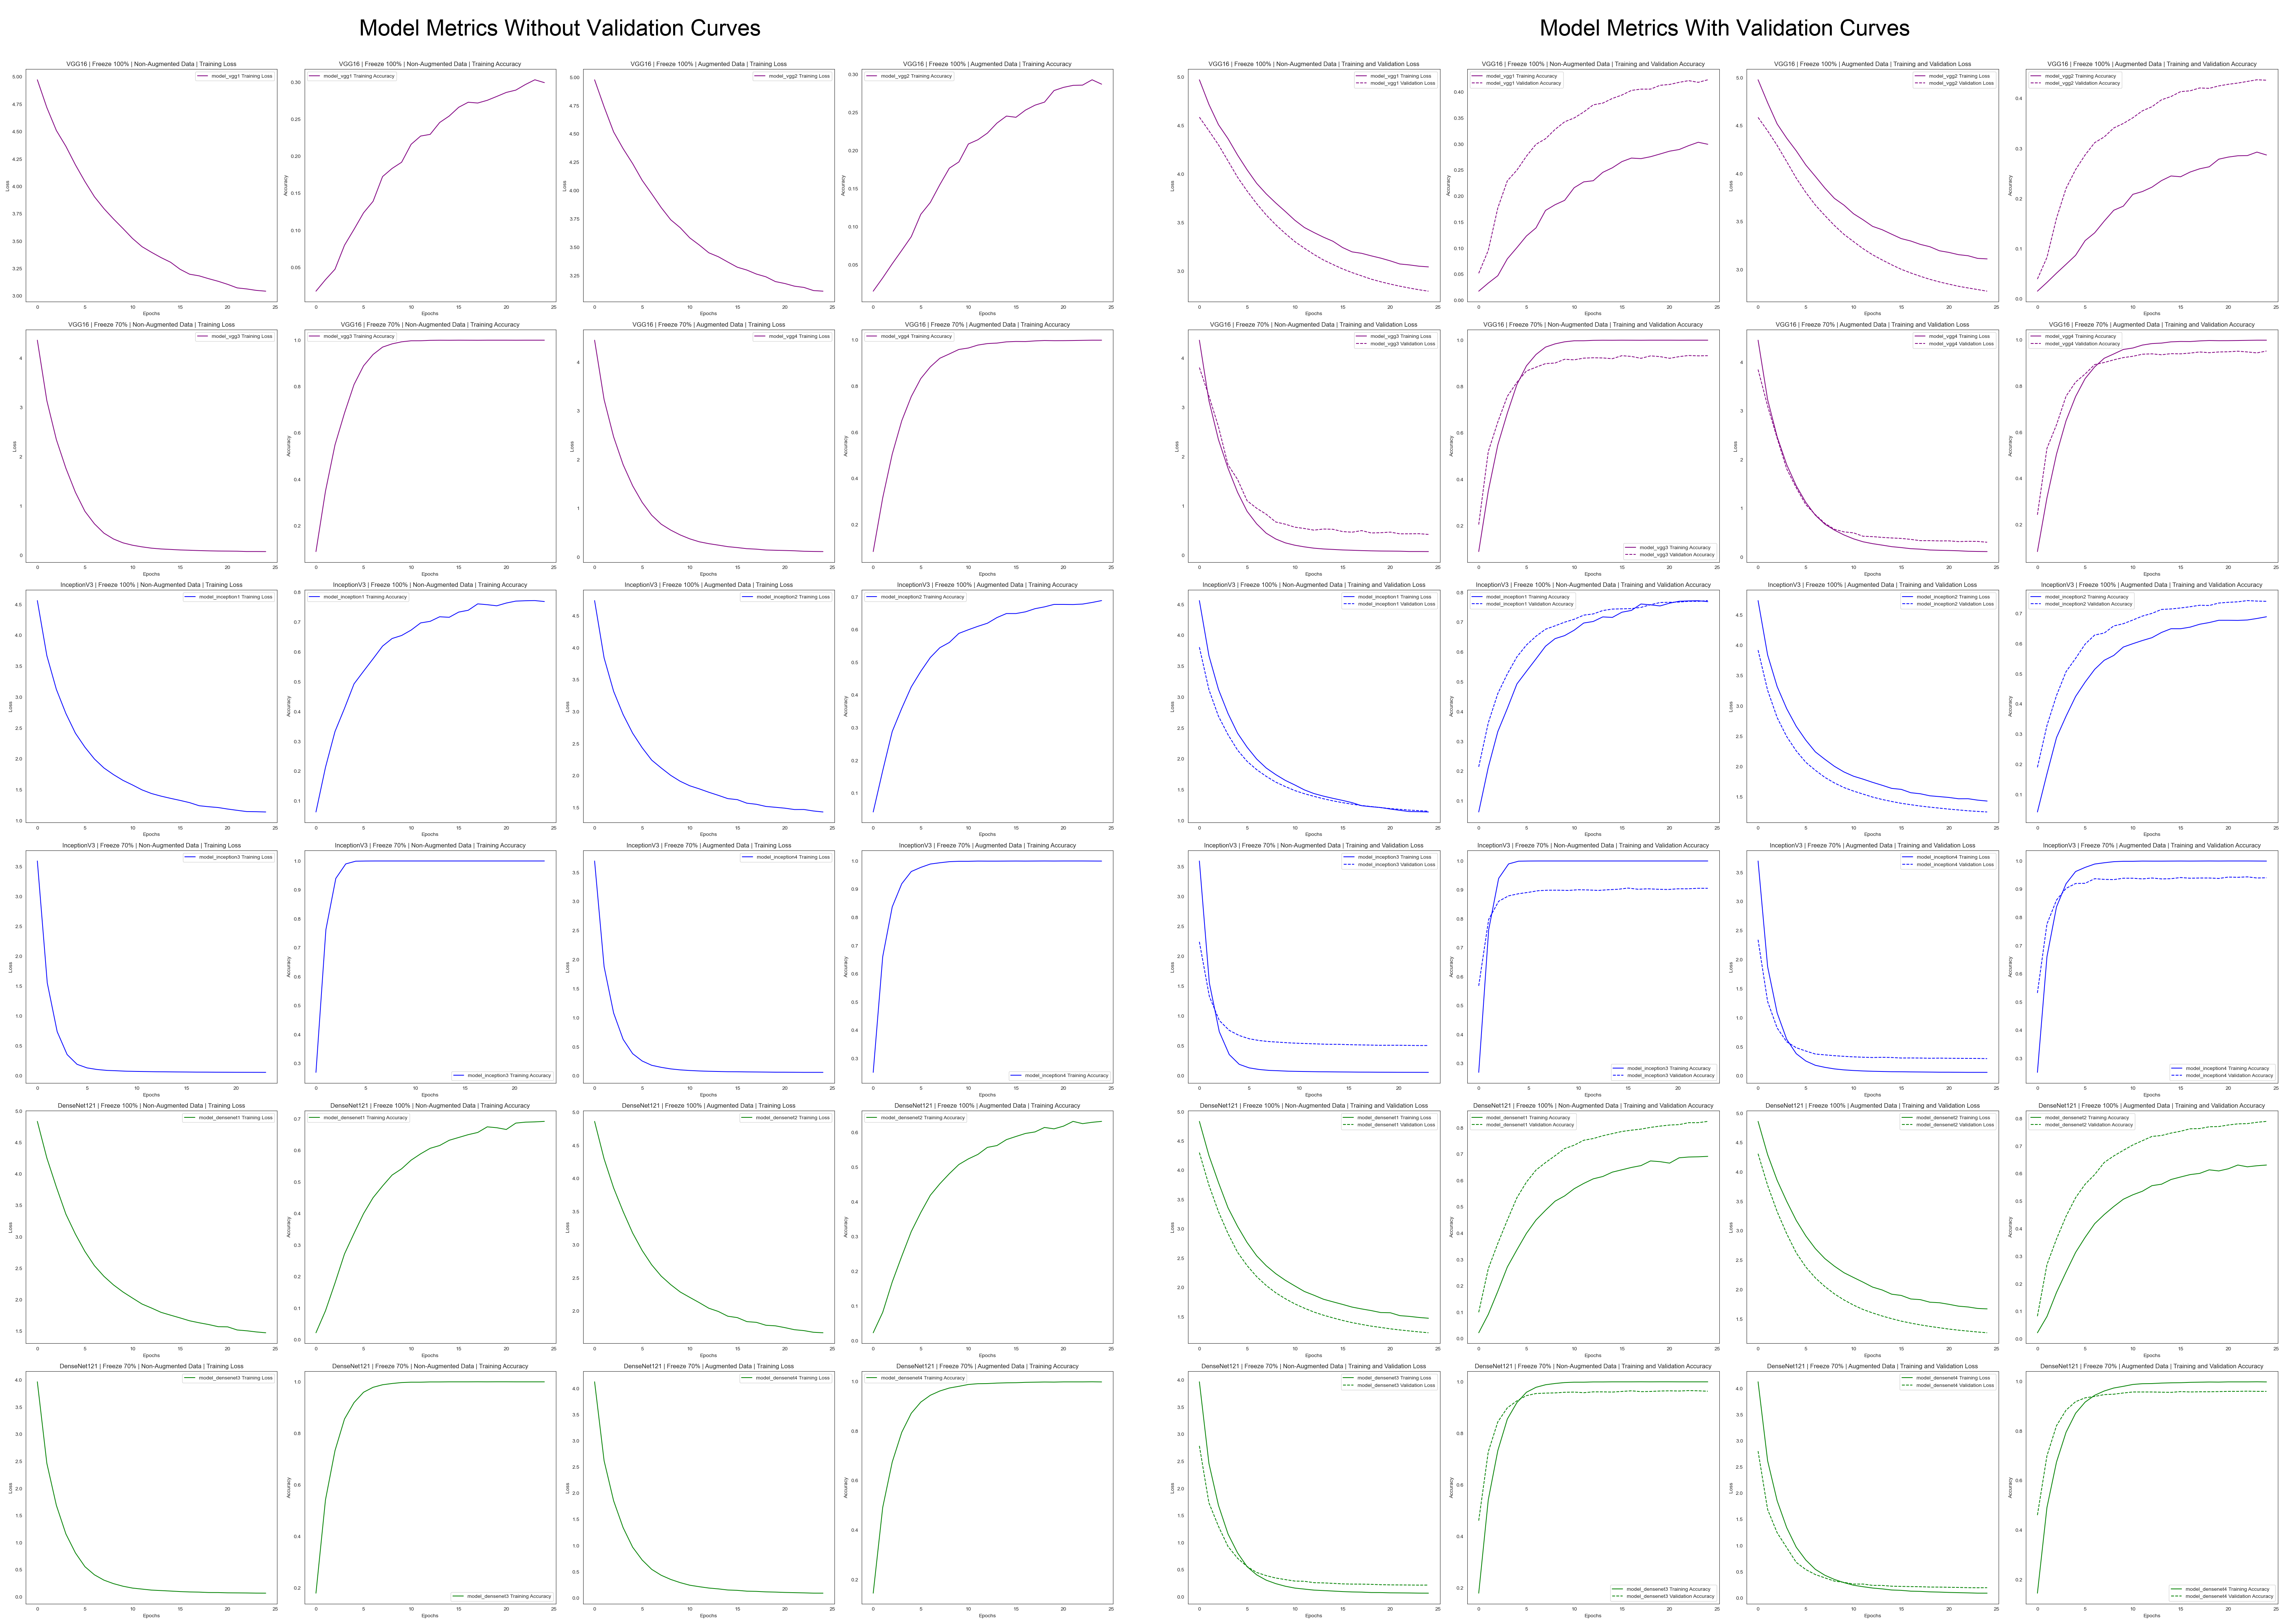

In [12]:
import pickle
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as IPImage, display

os.makedirs('Images', exist_ok=True)

def load_histories(models_dir):
    """
    Loads training and validation histories from pickle files stored in directories for each model.

    Args:
        models_dir (str): Path to the parent directory containing subdirectories for each model.

    Returns:
        dict: A dictionary containing model histories. The keys are model names ('vgg', 'densenet', 'inception'),
              and the values are lists of tuples, each containing the model directory and its corresponding history.
    """
    histories = {'vgg': [], 'densenet': [], 'inception': []}

    # Loop over model directories
    for model_dir in os.listdir(models_dir):
        model_path = os.path.join(models_dir, model_dir)
        if os.path.isdir(model_path):
            history_file = os.path.join(model_path, 'history.pkl')

            # Check if the history file exists, then load its content
            if os.path.exists(history_file):
                with open(history_file, 'rb') as f:
                    history = pickle.load(f)

                # Categorize history based on model name
                if 'vgg' in model_dir.lower():
                    histories['vgg'].append((model_dir, history))
                elif 'densenet' in model_dir.lower():
                    histories['densenet'].append((model_dir, history))
                elif 'inception' in model_dir.lower():
                    histories['inception'].append((model_dir, history))

    return histories

def plot_metrics_without_validation(histories, file_path):
    """
    Plots training loss and accuracy for different models without validation metrics.

    Args:
        histories (dict): A dictionary containing model histories.
        file_path (str): Path to save the generated plot.

    Returns:
        None
    """
    models = {'vgg': 'VGG16', 'densenet': 'DenseNet121', 'inception': 'InceptionV3'}
    colors = {'vgg': 'purple', 'densenet': 'green', 'inception': 'blue'}

    # Create figure for plotting
    plt.figure(figsize=(30, 42))

    # Loop through each model and its experiments
    for row, model_name in enumerate(['vgg', 'inception', 'densenet']):
        sorted_experiments = sorted(histories[model_name], key=lambda x: x[0])

        for col, (experiment_name, history) in enumerate(sorted_experiments):
            index = row * len(sorted_experiments) * 2 + col * 2

            # Determine freeze percentage and augmentation type based on experiment name suffix
            if experiment_name.endswith("1"):
                freeze_percentage = 1
                augmentation = 'Non-Augmented'
            elif experiment_name.endswith("2"):
                freeze_percentage = 1
                augmentation = 'Augmented'
            elif experiment_name.endswith("3"):
                freeze_percentage = 0.7
                augmentation = 'Non-Augmented'
            elif experiment_name.endswith("4"):
                freeze_percentage = 0.7
                augmentation = 'Augmented'

            # Plot training loss
            plt.subplot(6, 4, index + 1)
            plt.plot(history.history.get('loss', []), label=f'{experiment_name} Training Loss', color=colors[model_name])
            plt.title(f'{models[model_name]} | Freeze {int(freeze_percentage * 100)}% | {augmentation} Data | Training Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            # Plot training accuracy
            plt.subplot(6, 4, index + 2)
            plt.plot(history.history.get('accuracy', []), label=f'{experiment_name} Training Accuracy', color=colors[model_name])
            plt.title(f'{models[model_name]} | Freeze {int(freeze_percentage * 100)}% | {augmentation} Data | Training Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()

def plot_metrics_with_validation(histories, file_path):
    """
    Plots training and validation loss and accuracy for different models.

    Args:
        histories (dict): A dictionary containing model histories.
        file_path (str): Path to save the generated plot.

    Returns:
        None
    """
    models = {'vgg': 'VGG16', 'densenet': 'DenseNet121', 'inception': 'InceptionV3'}
    colors = {'vgg': 'purple', 'densenet': 'green', 'inception': 'blue'}

    plt.figure(figsize=(30, 42))

    # Loop through each model and its experiments
    for row, model_name in enumerate(['vgg', 'inception', 'densenet']):
        sorted_experiments = sorted(histories[model_name], key=lambda x: x[0])

        for col, (experiment_name, history) in enumerate(sorted_experiments):
            index = row * len(sorted_experiments) * 2 + col * 2

            # Determine freeze percentage and augmentation type based on experiment name suffix
            if experiment_name.endswith("1"):
                freeze_percentage = 1
                augmentation = 'Non-Augmented'
            elif experiment_name.endswith("2"):
                freeze_percentage = 1
                augmentation = 'Augmented'
            elif experiment_name.endswith("3"):
                freeze_percentage = 0.7
                augmentation = 'Non-Augmented'
            elif experiment_name.endswith("4"):
                freeze_percentage = 0.7
                augmentation = 'Augmented'

            # Plot training and validation loss
            plt.subplot(6, 4, index + 1)
            plt.plot(history.history.get('loss', []), label=f'{experiment_name} Training Loss', color=colors[model_name])
            plt.plot(history.history.get('val_loss', []), linestyle='--', label=f'{experiment_name} Validation Loss', color=colors[model_name])
            plt.title(f'{models[model_name]} | Freeze {int(freeze_percentage * 100)}% | {augmentation} Data | Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            # Plot training and validation accuracy
            plt.subplot(6, 4, index + 2)
            plt.plot(history.history.get('accuracy', []), label=f'{experiment_name} Training Accuracy', color=colors[model_name])
            plt.plot(history.history.get('val_accuracy', []), linestyle='--', label=f'{experiment_name} Validation Accuracy', color=colors[model_name])
            plt.title(f'{models[model_name]} | Freeze {int(freeze_percentage * 100)}% | {augmentation} Data | Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()

def add_title_to_image(image, title):
    """
    Adds a title to an image by resizing and drawing text at the top.

    Args:
        image (PIL.Image.Image): The image to which the title will be added.
        title (str): The title text to be added to the image.

    Returns:
        PIL.Image.Image: A new image with the title added at the top.
    """
    width, height = image.size
    new_height = height + 150  # Increase image height for the title

    # Create a new image with extra space for the title
    new_image = Image.new('RGB', (width, new_height), (255, 255, 255))
    new_image.paste(image, (0, 150))  # Paste the original image below the title area

    draw = ImageDraw.Draw(new_image)

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/helvetica/HelveticaNeue.ttf", 60)
    except IOError:
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/msttcorefonts/Arial.ttf", 60)
        except IOError:
            try:
                font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 60)
            except IOError:
                font = ImageFont.load_default()  # Use default font if none of the above are found

    # Draw the title text centered at the top of the image
    text_bbox = draw.textbbox((0, 0), title, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    draw.text(((width - text_width) / 2, 40), title, font=font, fill="black")

    return new_image

def combine_images(image_path1, image_path2, output_path, spacing=70):
    """
    Combines two images horizontally with a specified spacing between them.

    Args:
        image_path1 (str): Path to the first image.
        image_path2 (str): Path to the second image.
        output_path (str): Path to save the combined image.
        spacing (int, optional): The horizontal spacing between the two images. Default is 70.

    Returns:
        None
    """
    image1 = Image.open(image_path1)
    image2 = Image.open(image_path2)

    # Calculate the combined image dimensions
    combined_width = image1.width + image2.width + spacing
    combined_height = max(image1.height, image2.height)

    # Create a new image with the combined dimensions
    combined = Image.new('RGB', (combined_width, combined_height), (255, 255, 255))

    # Paste the images side by side with the specified spacing
    combined.paste(image1, (0, 0))
    combined.paste(image2, (image1.width + spacing, 0))

    # Save the combined image
    combined.save(output_path)

# Main script execution
models_dir = "Models"
histories = load_histories(models_dir)

# File paths for the images
image1_path = 'Images/metrics_without_validation.png'
image2_path = 'Images/metrics_with_validation.png'
combined_image_path = 'Images/combined_metrics.png'

# Plot the metrics and save the images
plot_metrics_without_validation(histories, image1_path)
plot_metrics_with_validation(histories, image2_path)

# Add titles to the images
image1 = Image.open(image1_path)
image1_with_title = add_title_to_image(image1, "Model Metrics Without Validation Curves")
image1_with_title.save(image1_path)

image2 = Image.open(image2_path)
image2_with_title = add_title_to_image(image2, "Model Metrics With Validation Curves")
image2_with_title.save(image2_path)

# Combine the images and display the result
combine_images(image1_path, image2_path, combined_image_path, spacing=120)
display(IPImage(combined_image_path))

## 🧬 Analysing the Results

In this cell, we perform a detailed analysis of the experimental setups. First of all, the code checks for the existence of a results file (`results.csv`) to avoid redundant computations. If the file exists, the results are read directly; otherwise, the evaluation process is initiated. The evaluation process involves defining helper functions to systematically assess the models: the `evaluate` function computes metrics for training, validation, and test datasets. Additionally, it predicts class labels for the test set and generates a comprehensive classification report using `sklearn.metrics.classification_report`. This report provides precision, recall, F1-score, and support for each class. The `load_models_and_durations` function iterates through directories to load pre-trained models along with their training durations. These durations, stored in text files, offer useful information into the computational cost of training each model. After loading the models and their corresponding durations, the code evaluates each model against its respective datasets. The evaluation results include metrics such as accuracy and loss for training, validation, and testing phases. These metrics are stored in structured lists and subsequently organized into a pandas DataFrame. The generated DataFrame includes key columns:

- **Model Name:** identifies each model uniquely
- **Duration:** training time for the model
- **Train Accuracy and Loss:** metrics from the training dataset, showing how well the model learned during training
- **Validation Accuracy and Loss:** metrics from the validation dataset, used to monitor generalization during training
- **Test Accuracy and Loss:** metrics from the test dataset, indicating final model performance on unseen data
- **Predictions:** predicted class labels for the test set
- **Reports:** detailed classification reports in plain text for each model

Finally, the DataFrame is saved to a CSV file for reference. For conciseness, the 'Reports' column is excluded from the printed output in this cell, as it contains verbose data better suited for detailed post-analysis. In fact, the 'Reports' column will be used in the next code cell, to print a classification report of the best model. Let's now use this dataframe to conduct an analysis of model performances. First of all, let's recall that models ending in `"2"` or `"4"` use augmented data, while models ending in `"1"` or `"3"` employ non-augmented data. Additionally, we recall that the `"freeze_percentage"` value indicates the proportion of pre-trained layers frozen during training, with models ending in `"3"` and `"4"` freezing `70%` of the layers, while models ending in `"1"` and `"2"` freeze all pre-trained layers. The experiments exhibit a high range of training accuracies, from as low as `45%` (`model_vgg2`) to a perfect `99-100%` (`model_vgg4`, `model_densenet3`, `model_densenet4`, and so on). However, the high training accuracies observed must be interpreted with caution, as they may indicate overfitting, particularly when paired with relatively lower validation/test accuracies. In this regard, test accuracy is a key indicator of a model's ability to generalize to unseen data. We note that the models with the higher freeze percentage show relatively lower test accuracies, indicating that these models may not generalize well. Models that instead use a `70%` freeze percentage exhibit better generalization with test accuracies nearing or above `90%`. In particular, `model_densenet3` demonstrate a remarkable test accuracy of `96.98%`, indicating their robustness in handling unseen data.

The models with data augmentation tend to show slightly improved test performance compared to their non-augmented counterparts. The augmentation process helps prevent overfitting by introducing variation in the data, which may explain the superior test accuracies. This, however, comes at a cost: experiments without data augmentation take around `15-20` minutes to train (using Google Colab's T4 GPU Hardware Accelerator), while experiments with data augmentation take around `50` minutes to train. Depending on the hardware the models are trained on, it may not always be worth choosing to perform data augmentation. In particular, for DenseNet, we see that the un-augmented `model_densenet3` performs better on the test set (`96.98%`) than `model_densenet4` (`96.90%`), which has been augmented. So, not only does the model take more than three times longer to train (`0:16:11 vs 0:52:16`), it actually performs worse in terms of test accuracy! From the analysis of the dataframe, we can also gather further insights. For example, loss values also provide insight into model behavior. High training loss values paired with high test loss, such as in `model_vgg1`, `model_vgg2`, and `model_inception1`, suggest that these models struggle to fit the data properly. On the other hand, models like `model_densenet3`, `model_densenet4`, `model_inception3`, and `model_inception4` exhibit lower loss values, which align with their higher generalization abilities. What is evident is that, comparing all the metrics in question, the best model, both in terms of time and performance, is `model_densenet3`. In fact, this model, even without data augmentation, is able to provide surprising performances in the classification task proposed by this notebook. Although its train loss and validation loss are slightly higher than its counterpart `model_densenet4`, the training times and the better train accuracy and validation accuracy values lead us to think that `model_densenet3` is the best compromise between training times and performance. Therefore, it will be the model that we will analyze in-depth in the following code cell.

In [13]:
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
import pandas as pd
import os

# Suppress  TensorFlow logs to reduce console clutter by setting the logging level to '2',
# which filters out DEBUG and INFO messages, showing only warnings and errors.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Define the file path where results will be saved
results_file_path = 'Models/results.csv'

# Check if results file already exists
if os.path.exists(results_file_path):
    results_df = pd.read_csv(results_file_path)  # Read existing results from CSV file
    print("❗The file 'results.csv' already exists. There is no need to recreate it. Below are its contents:")
else:
    true_classes = np.argmax(test_generator.labels, axis=1)  # Get the true class labels for evaluation

    def evaluate(model, train, valid, test):
        """
        Evaluates a given model on training, validation, and test datasets.

        Args:
            model (tf.keras.Model): The model to be evaluated.
            train (tf.data.Dataset): The training dataset.
            valid (tf.data.Dataset): The validation dataset.
            test (tf.data.Dataset): The test dataset.

        Returns:
            tuple: A tuple containing the evaluation scores for training, validation, and test datasets,
                   the predicted class labels for the test set, and a classification report.
        """
        # Evaluate the model on training, validation, and test datasets
        score_training = model.evaluate(train, verbose=0)
        score_validation = model.evaluate(valid, verbose=0)
        score_test = model.evaluate(test, verbose=0)

        # Predict class labels for the test set and generate classification report
        predicted_classes = np.argmax(model.predict(test, verbose=0), axis=1)
        report = classification_report(true_classes, predicted_classes, zero_division=0)

        return score_training, score_validation, score_test, predicted_classes, report

    def load_models_and_durations(models_dir):
        """
        Loads models from a specified directory and retrieves their training durations.

        Args:
            models_dir (str): Path to the directory containing model subdirectories.

        Returns:
            dict: A dictionary categorizing models by architecture type, with corresponding model objects
                  and training durations.
        """
        models = {'vgg': [], 'densenet': [], 'inception': []}

        # Iterate through model directories and load the models and durations
        for model_dir in os.listdir(models_dir):
            model_path = os.path.join(models_dir, model_dir)
            if os.path.isdir(model_path):
                model_file = os.path.join(model_path, 'model.keras')
                if os.path.exists(model_file):
                    model = tf.keras.models.load_model(model_file)

                    # Retrieve the training duration for the model
                    duration_file = os.path.join(model_path, 'duration.txt')
                    if os.path.exists(duration_file):
                        with open(duration_file, 'r') as f:
                            duration = f.read().strip()
                    else:
                        duration = 'Unknown'

                    # Classify models by their architecture type
                    if 'vgg' in model_dir.lower():
                        models['vgg'].append((model_dir, model, duration))
                    elif 'densenet' in model_dir.lower():
                        models['densenet'].append((model_dir, model, duration))
                    elif 'inception' in model_dir.lower():
                        models['inception'].append((model_dir, model, duration))

        return models

    models_dir = 'Models'  # Directory containing models
    models_dict = load_models_and_durations(models_dir)  # Load models and their durations

    # Initialize lists to store results for each model
    models_name = []
    models = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []
    test_loss = []
    predictions = []
    reports = []
    durations = []

    # Evaluate each model and store results
    for model_group, model_list in models_dict.items():
        for model_dir, model, duration in model_list:
            models.append(model)
            models_name.append(model_dir)
            durations.append(duration)

            # Select training data based on the model directory name
            if '1' in model_dir:
                train_data = train_generator
            else:
                train_data = train_generator_aug

            # Evaluate model and retrieve performance metrics
            training_score, validation_score, test_score, predicted, report = evaluate(model, train_data, valid_generator, test_generator)

            # Append evaluation results to corresponding lists
            train_accuracy.append(training_score[1])
            train_loss.append(training_score[0])
            val_accuracy.append(validation_score[1])
            val_loss.append(validation_score[0])
            test_accuracy.append(test_score[1])
            test_loss.append(test_score[0])
            predictions.append(predicted)
            reports.append(report)

    # Create a DataFrame with the results
    results = {
        'Model Name': models_name,
        'Duration': durations,
        'Train Accuracy': train_accuracy,
        'Train Loss': train_loss,
        'Val Accuracy': val_accuracy,
        'Val Loss': val_loss,
        'Test Accuracy': test_accuracy,
        'Test Loss': test_loss,
        'Predictions': predictions,
        'Reports': reports
    }

    results_df = pd.DataFrame(results)  # Convert results to a pandas DataFrame
    results_df.to_csv(results_file_path, index=False)  # Save results to CSV file
    print("Results have been saved to the file 'results.csv':")

# Exclude the 'Reports' column from being printed to reduce visual clutter,
# as it contains large strings that will become useful in the next code cell
results_df.drop(columns=['Reports'])

❗The file 'results.csv' already exists. There is no need to recreate it. Below are its contents:


Model Name Duration  Train Accuracy  Train Loss  Val Accuracy  \
0         model_vgg1  0:17:01        0.462666    2.698613      0.422638   
1         model_vgg2  0:52:44        0.450803    2.801461      0.436482   
2         model_vgg3  0:18:44        0.990928    0.175148      0.933225   
3         model_vgg4  0:52:25        1.000000    0.057503      0.951140   
4    model_densenet1  0:15:55        0.862526    1.077847      0.823290   
5    model_densenet2  0:50:10        0.806699    1.263437      0.789902   
6    model_densenet3  0:16:11        0.996685    0.087682      0.965798   
7    model_densenet4  0:52:16        0.999651    0.041136      0.961726   
8   model_inception2  0:36:10        0.791870    1.152743      0.742671   
9   model_inception3  0:14:45        0.976622    0.225643      0.901466   
10  model_inception4  0:45:28        1.000000    0.049704      0.942997   
11  model_inception1  0:15:00        0.886078    0.831900      0.771173   

    Val Loss  Test Accuracy  Test Loss              Predictions  
0   2.793970       0.442636   2.776671  [93 46 55 ... 88  9 93]  
1   2.792042       0.449146   2.790899  [93 46 55 ... 88 91  5]  
2   0.434702       0.930838   0.425593  [52 46  4 ... 15 37 78]  
3   0.305436       0.947111   0.316803  [52 46  4 ... 15 37 78]  
4   1.227489       0.811229   1.224897  [50 46  4 ... 47 37 78]  
5   1.265702       0.781123   1.254841  [50 46  4 ... 88 76 78]  
6   0.219276       0.969894   0.221566  [52 46  4 ... 15 37 78]  
7   0.195604       0.969081   0.179224  [52 46  4 ... 15 37 78]  
8   1.274363       0.743694   1.257458  [52 46  4 ... 88 37 78]  
9   0.519808       0.902360   0.522909  [52 46  4 ... 15 37 78]  
10  0.301577       0.941416   0.282513  [52 46  4 ... 15 37 78]  
11  1.154796       0.775427   1.164543  [52 46  4 ... 50 37 78]

## 🥇 Choosing the Best Model

Based on the analysis just conducted, `model_densenet3` has been identified as the best-performing model, offering a strong balance between training times and classification accuracy. In this code cell, we will conduct a deeper analysis of `model_densenet3` using its classification report and confusion matrix to understand its performance in greater detail. The classification report for `model_densenet3` reveals remarkable performance across all classes. The precision, recall, and F1-score values are consistently high, with many classes achieving perfect scores (`1.00`), indicating the model's excellent ability to correctly identify the majority of the samples for these classes. The macro and weighted averages of `0.97` for accuracy highlight that the model performs equally well on average across all classes, without significant bias toward any particular class. The model performs particularly well on smaller classes, with precision and recall near perfect in many cases. However, there are some instances where recall dips slightly, such as in class `2`, which has a recall of `0.67` but still maintains a decent F1-score of `0.80`. Despite these small variations, `model_densenet3` proves to be a very strong performer, effectively handling a diverse set of categories with high accuracy and balanced metrics, which justifies its selection as the best model.

The confusion matrix visualization for `model_densenet3` provides additional insights that strongly support our previous conclusions about the model's performance. The most striking feature is the prominent diagonal line from the top-left to bottom-right, representing correct classifications. This strong pattern indicates that the model achieves high accuracy across the vast majority of classes. The matrix's sparsity outside the main diagonal is particularly noteworthy - there are very few off-diagonal elements, and those that exist appear in light colors, indicating minimal misclassifications. The scattered yellow markers represent the few cases where misclassifications occurred, but their relative scarcity and distribution pattern suggest these are isolated incidents rather than systematic errors. This detailed matrix visualization reinforces our earlier analysis of the classification metrics. The clear dominance of correct classifications along the diagonal, combined with the minimal and well-distributed nature of the errors, provides strong visual confirmation that `model_densenet3` is indeed achieving the high performance indicated by its statistical metrics. The absence of any significant error patterns or clusters in the confusion matrix also suggests that the model has successfully learned discriminative features for each class, without showing undue bias toward any particular category.

_Note: for reference purposes, a compressed version of the confusion matrix has also been printed and saved, reporting only the rows and columns that yielded classification errors, to allow for greater readability._

Classification Report (model_densenet3):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9
           2       1.00      0.67      0.80         6
           3       0.83      0.62      0.71         8
           4       0.90      1.00      0.95         9
           5       0.86      1.00      0.92         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00        13
           8       1.00      0.86      0.92         7
           9       1.00      1.00      1.00         6
          10       0.81      1.00      0.90        13
          11       0.81      1.00      0.90        13
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00         7
          14       0.88      1.00      0.93         7
          15       1.00      0.83      0.91         6
          16       0.92      0.92      

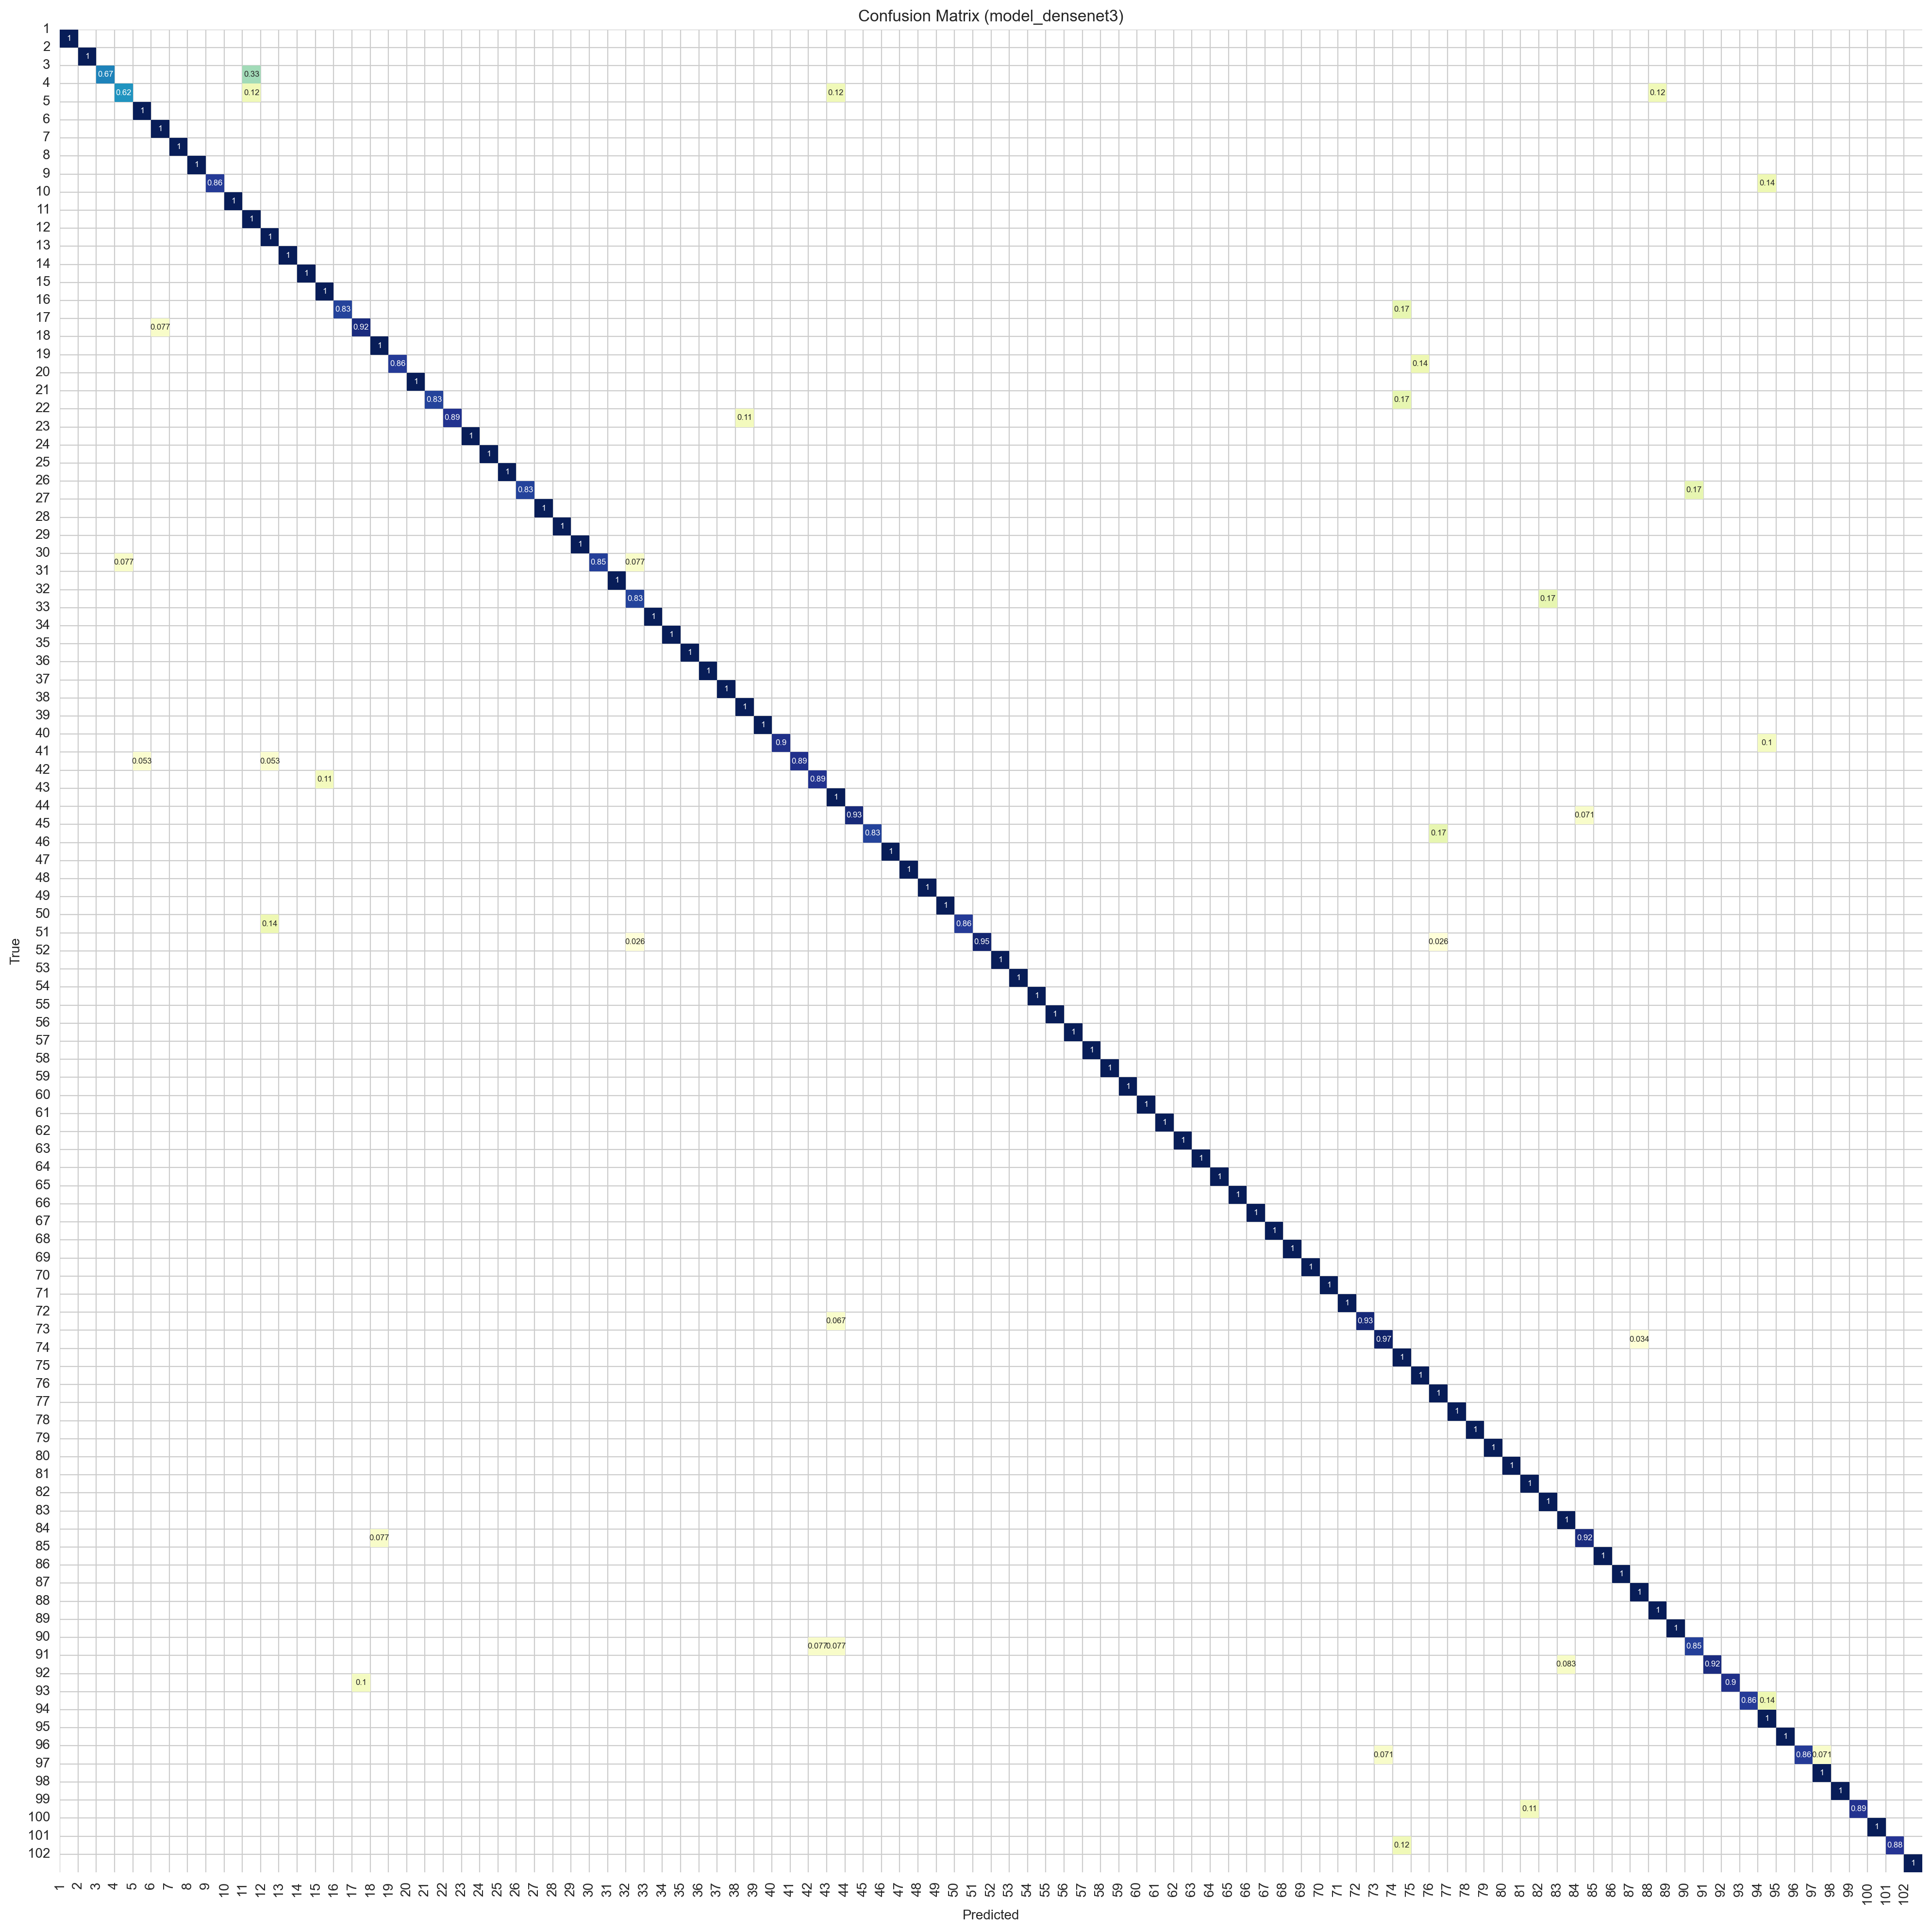

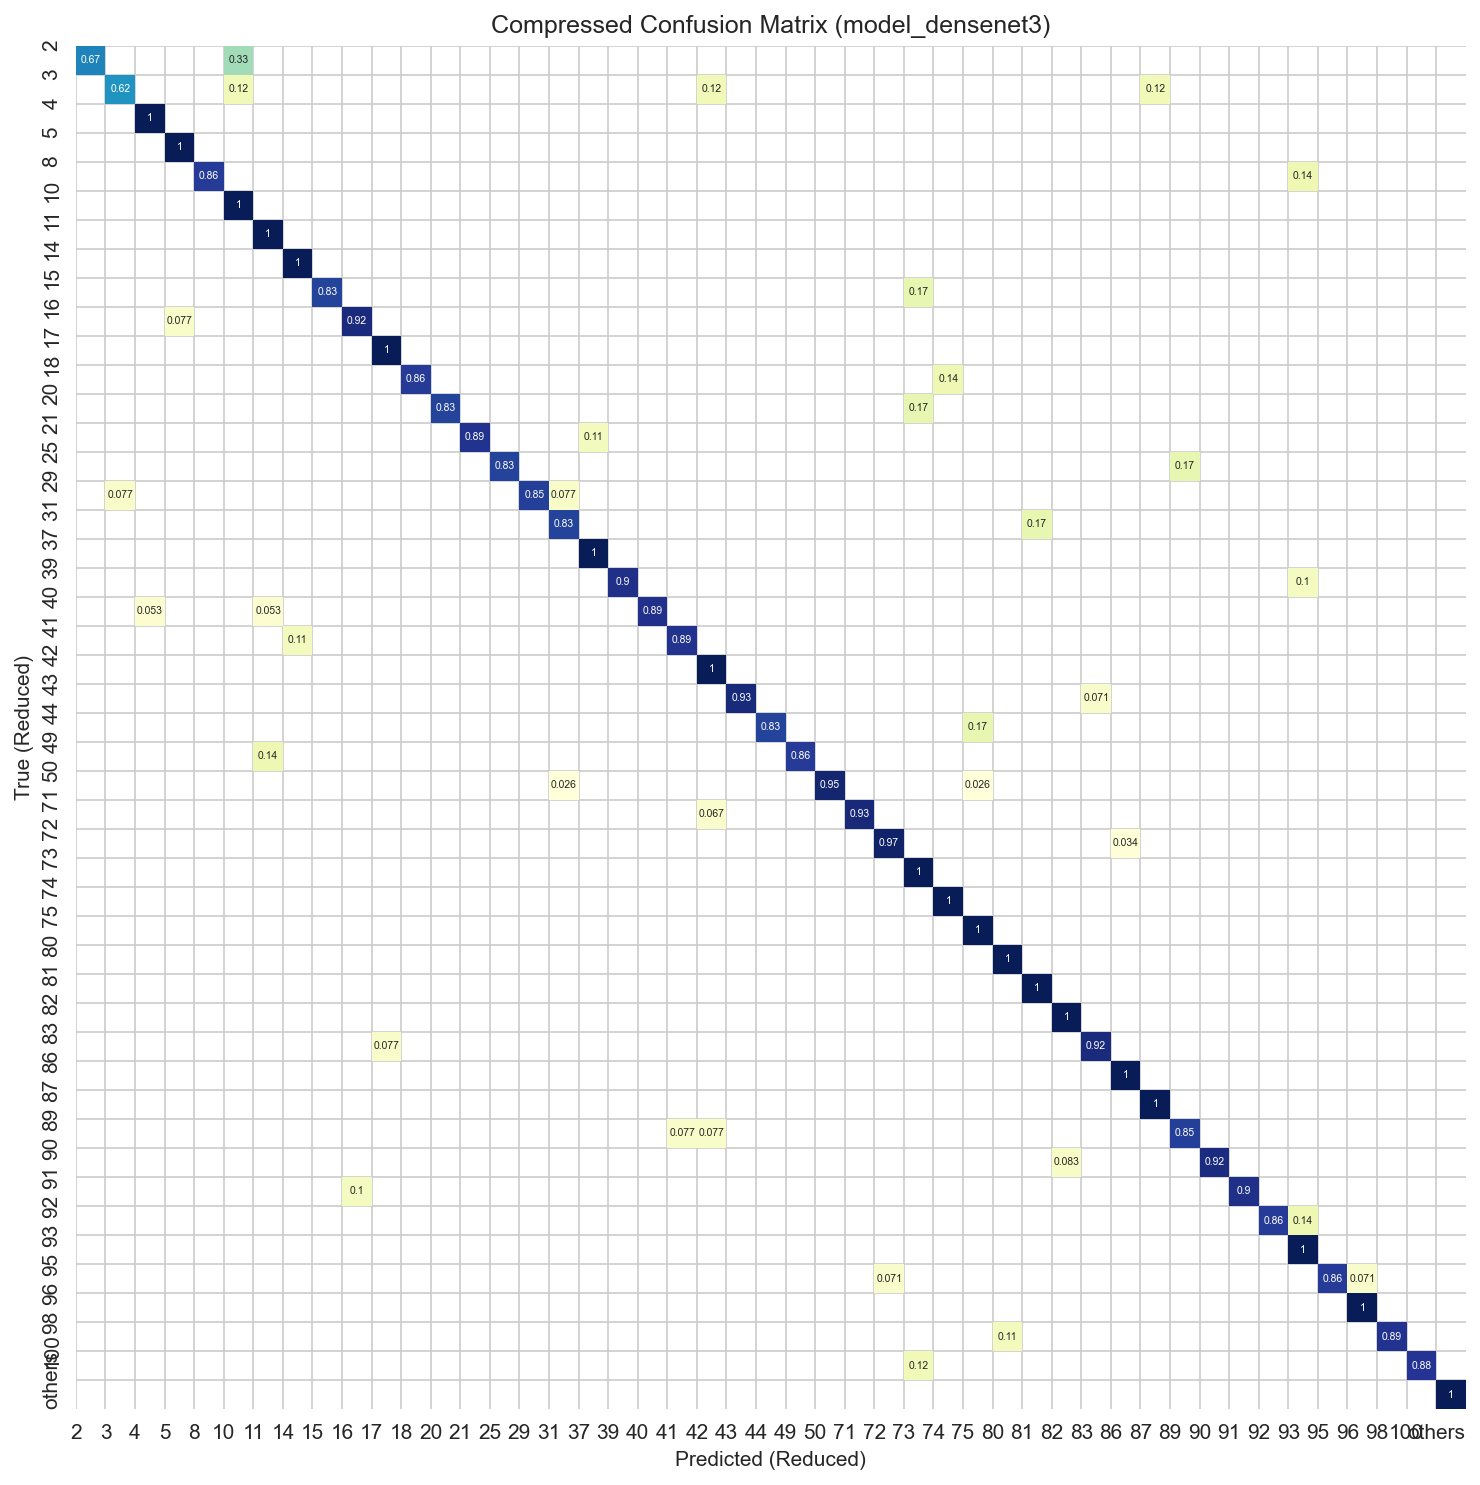

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Define the name of the best-performing model to be analyzed
best_model_name = 'model_densenet3'

# Extract the classification report of the best model from a DataFrame
# Assumes 'results_df' is pre-defined and contains a 'Reports' column with model performance metrics
model_report = results_df.loc[results_df['Model Name'] == best_model_name, 'Reports'].values[0]

# Load the pre-trained model from the specified directory
# Assumes TensorFlow's Keras is being used and the model is saved in the '.keras' format
best_model = tf.keras.models.load_model(f'Models/{best_model_name}/model.keras')

# Extract the ground truth labels for the test set
# Assumes 'test_df' is a DataFrame with a 'label' column containing the true class labels
y_true = test_df['label'].values

# Generate predictions for the test set using the best-performing model
# Assumes 'test_generator' is a data generator yielding batches of test data
# Use np.argmax to obtain predicted class labels from model's probability output
y_pred = np.argmax(best_model.predict(test_generator, verbose=0), axis=1)

# Compute the normalized confusion matrix.
# Normalization ensures the values represent proportions instead of absolute counts
confusion_mat = confusion_matrix(y_true, y_pred, normalize='true')

# Print the classification report for the best model.
# This provides detailed performance metrics (e.g., precision, recall, F1-score)
print(f"Classification Report ({best_model_name}):\n")
print(model_report)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(20, 20), dpi=200)  # Set the figure size and resolution
sns.heatmap(confusion_mat, annot=True, cmap="YlGnBu", mask=(confusion_mat <= 0),
            annot_kws={"size": 6}, cbar=False)  # Customize annotations and hide the color bar
plt.xlabel('Predicted')  # Label for the x-axis (predicted class labels)
plt.ylabel('True')  # Label for the y-axis (true class labels)
plt.title(f'Confusion Matrix ({best_model_name})')  # Add a title to the plot

# Set the tick labels to match the class indices
plt.xticks(ticks=range(len(confusion_mat)), labels=range(1, len(confusion_mat) + 1))
plt.yticks(ticks=range(len(confusion_mat)), labels=range(1, len(confusion_mat) + 1))

# Adjust layout to prevent overlapping elements and ensure clarity of the plot
plt.tight_layout()

# Display the confusion matrix plot
plt.grid('on')  # Add grid lines for reference
plt.show()

def group_classes_without_errors(confusion_matrix):
    """
    Groups classes in a confusion matrix, identifying those without errors.

    This function examines a given confusion matrix to determine which classes
    are "error-free," meaning their predictions are perfectly aligned with their
    ground truth. These classes are then grouped into a single "others" category
    in a new reduced confusion matrix.

    Parameters:
    ----------
    confusion_matrix : numpy.ndarray
        The confusion matrix to analyze. It is assumed to be a square matrix
        where rows represent true labels and columns represent predicted labels.

    Returns:
    -------
    tuple
        A tuple containing:
        - new_matrix (numpy.ndarray): The reduced confusion matrix with the
          "others" category included.
        - error_classes (list): A list of remaining error-prone classes
          combined with the "others" category label.
    """
    classes_without_errors = []  # List to store indices of classes without errors.

    # Iterate through each class to check for "error-free" criteria.
    for i in range(len(confusion_matrix)):
        row = confusion_matrix[i]  # Row corresponding to the current class.
        column = confusion_matrix[:, i]  # Column corresponding to the current class.

        # Check if the class is error-free: sum of row/column matches the diagonal element.
        if np.sum(row) == row[i] and np.sum(column) == column[i]:
            classes_without_errors.append(i)

    # Create a list of classes with errors (those not in classes_without_errors).
    classes = list(range(len(confusion_matrix)))  # All class indices.
    error_classes = list(set(classes) - set(classes_without_errors))  # Error-prone classes.

    # Initialize the new reduced confusion matrix.
    new_size = len(error_classes) + 1  # Include "others" category.
    new_matrix = np.zeros((new_size, new_size))  # Reduced confusion matrix.

    # Populate the reduced confusion matrix with error-prone class data.
    ni = 0  # Row index for the new matrix.
    for i in error_classes:
        nj = 0  # Column index for the new matrix.
        for j in error_classes:
            new_matrix[ni][nj] = confusion_matrix[i][j]  # Copy values for error-prone classes.
            nj += 1
        ni += 1

    # Set the bottom-right corner for the "others" category.
    new_matrix[-1][-1] = 1

    # Return the reduced matrix and updated labels (including 'others').
    return new_matrix, error_classes + ['others']

# Example usage:
new_matrix, new_label = group_classes_without_errors(confusion_mat)

# Plotting the reduced confusion matrix.
plt.figure(figsize=(10, 10), dpi=150)

# Use a heatmap to visualize the reduced confusion matrix.
sns.heatmap(
    new_matrix,
    annot=True,
    cmap="YlGnBu",
    mask=(new_matrix <= 0),  # Mask cells with non-positive values.
    annot_kws={"size": 5},
    cbar=False
)

# Labeling the plot for clarity.
plt.xlabel('Predicted (Reduced)')
plt.xticks(range(len(new_label)), new_label)  # X-axis labels.
plt.yticks(range(len(new_label)), new_label)  # Y-axis labels.
plt.ylabel('True (Reduced)')
plt.title(f'Compressed Confusion Matrix ({best_model_name})')

# Adjust layout for better visualization.
plt.tight_layout()
plt.grid('on')  # Add grid lines for reference.
plt.show()

# Funzione per unire due immagini affiancate
def combine_images(image1_path, image2_path, output_path):
    """
    Combina due immagini affiancandole orizzontalmente.

    Parametri:
    ----------
    image1_path : str
        Percorso del file della prima immagine.
    image2_path : str
        Percorso del file della seconda immagine.
    output_path : str
        Percorso del file di output per l'immagine combinata.
    """
    img1 = Image.open(image1_path)
    img2 = Image.open(image2_path)

    # Assicuriamoci che entrambe le immagini abbiano la stessa altezza
    new_height = max(img1.height, img2.height)
    img1 = img1.resize((img1.width, new_height))
    img2 = img2.resize((img2.width, new_height))

    # Creiamo un'immagine vuota per l'output
    combined_width = img1.width + img2.width
    combined_image = Image.new('RGB', (combined_width, new_height))

    # Incolliamo le due immagini una accanto all'altra
    combined_image.paste(img1, (0, 0))
    combined_image.paste(img2, (img1.width, 0))

    # Salviamo l'immagine combinata
    combined_image.save(output_path)

# Salvataggio della matrice di confusione originale
plt.figure(figsize=(10, 10), dpi=150)
sns.heatmap(confusion_mat, annot=True, cmap="YlGnBu", mask=(confusion_mat <= 0),
            annot_kws={"size": 5}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix ({best_model_name})')
plt.tight_layout()
confusion_matrix_path = 'Images/confusion_matrix.png'
plt.savefig(confusion_matrix_path)
plt.close()

# Riduzione della matrice di confusione e salvataggio
new_matrix, new_label = group_classes_without_errors(confusion_mat)
plt.figure(figsize=(10, 10), dpi=150)
sns.heatmap(new_matrix, annot=True, cmap="YlGnBu", mask=(new_matrix <= 0),
            annot_kws={"size": 5}, cbar=False)
plt.xlabel('Predicted (Reduced)')
plt.xticks(range(len(new_label)), new_label)
plt.yticks(range(len(new_label)), new_label)
plt.ylabel('True (Reduced)')
plt.title(f'Compressed Confusion Matrix ({best_model_name})')
plt.tight_layout()
compressed_matrix_path = 'Images/compressed_confusion_matrix.png'
plt.savefig(compressed_matrix_path)
plt.close()

# Combinazione delle due immagini in una sola
combined_image_path = 'Images/combined_confusion_matrix.png'
combine_images(confusion_matrix_path, compressed_matrix_path, combined_image_path)